# Large Disaster Forecast: Can Census Inform County Level Projections
Questions:
1. Are **Female heads of households**, **households with people with disabilities**, **households with elderly people**, **working individuals** or **SNAP Recipients** good indicators of the number of registrations received by a county in a disaster?
2. Is there a meaningful way to sub-divide the data to reduce the variance?
3. Is there a relationship between the geographic characteristics of a county and the number of registrations received?

> This tool uses open source FEMA and Census data to investigate relationships between family types and size with disaster registrations. The datasets included in this forecast are the Census S2201 Subject Table and two FEMA tables--one for summary information and the other for Individual Assistance Registration counts. 

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from datetime import datetime
import requests
from io import BytesIO, StringIO
import seaborn as sns

import warnings
warnings.simplefilter(action = 'ignore',category = FutureWarning)
warnings.simplefilter(action = 'ignore',category = RuntimeWarning)
# warnings.simplefilter(action = 'ignore',category = SettingWithCopyWarning)



# Census API Key: Hashed
yourKeyGoesHere = 'XXXXXXXXXXX'

#Output the last script runtime
scriptBegin = datetime.now()
print(f'The script was last run on {scriptBegin}')
year = scriptBegin.year


The script was last run on 2022-12-18 08:49:00.661693


In [2]:
#Import Machine Learning Libraries: skLearn and StatsModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.cluster import KMeans
import statsmodels.api as sm

In [3]:
#Create a Range of years using Current Year date to enhance repeatability
min_year = 2014
max_year = year+1
max_census = 2021


# Functions
1. FEMA API Call
2. Census API Call S2201/DP02
3. Census dataframe conversion
4. Census Datatype conversions

## Function 1: Get FEMA Data from the FEMA API

In [4]:
def get_fema_data(url):
    '''
    Context: The purpose of this function is to generalize the connection to the FEMA API.
             The function accepts the url listed on the website and then adds a json extension.
             The json extension converts the data to a dictionary and then filters the keys for
             the most current data. Not all of the data structures are the same, so if the values
             to reduce the size of the dataset are available, the try and except clause attempts
             to reduce the values looped-in. 
             
    Args:   FEMA url for the api connection
    Output: Dataframe of the FEMA API
    '''
    
    #Convert the url of the data location to the 
    _url = f'{url}.json'
    
    #Use the requests library to get the URL and convert to JSON
    response = requests.get(_url) 
    response_json = response.json()
    
    #Create a loop that accesses the json values
    _data = []
    for key, value in response_json.items():
        #Convert to a dataframe using the DataFrame from dict function
        data = pd.DataFrame.from_dict(value)
        #Filter the Disaster Numbers between 4000 and 5000
        data = data[(data['disasterNumber'].astype(int)>=4000)\
               & (data['disasterNumber'].astype(int)<5000)]
        
        try:
            # Filter data by dropping unnecessary columns
            data = data[data['declarationType']=='DR']
            data = data.drop(['paProgramDeclared','hmProgramDeclared'], axis = 1)
            data = data.drop(['hash','id'], axis = 1)
            data = data.drop(['lastIAFilingDate'], axis = 1)
            data = data.drop(['lastRefresh'], axis = 1)
            data = data.drop(['zipCode','city'], axis = 1)
        except Exception as e:
            pass
        #Append the data to the instantiated variable data
        _data.append(data)
    
    #Convert to a dataframe and reset the index and return the dataframe
    _df = pd.DataFrame(pd.concat(_data, sort = False)).reset_index(drop = True)
    return _df
                       

## Function 2: Census Dataframe Conversion
* Converts the json read in by the api call into a dataframe. 

In [5]:
def json_to_dataframe(response):
    '''
    Convert response variable to dataframe
    '''
    return(pd.DataFrame(response.json()[1:],columns= response.json()[0]))

## Function 3: Generalizable Census API call
* Currently designed to access county level data
* Commented code can be modified using the same inputs to access tract level data

In [6]:
def census_county_detail(year, st_cd, table, elements, yourKeyGoesHere):
    '''
    Context: The purpose of this function is to generalize the connection to the Census api.
             Although Census has libraries this method is more generalizable to all api calls.
             This method calls on all of the county values (see for=county:*), but could be 
             used for Census Tract or Block values. Instantiating this function in a loop
             reduces the likelihood that the user will exceed the 'reasonable' amount of data
             that can be downloaded at any one time.
             
    Args:  
         - year:            This is the year derived from the range of years investigated range(min_year,max_year)
         - st_cd:           The fips state code number derived from the range of 1-72. Census requires a two
                            digit state number listed as a string. This is modified in the loop by adding a zero
                            and converting the value to a string
         - Table:           This is the type of Census table requested. Common Types are Profile and Subject
         - elements:        Census values to be read-in. They can be individual values or entire tables
         - yourKeyGoesHere: Census API Key. Must be requested from Census
                     
    
    Output: List created through the append statement of dataframes from the api call and years called
    '''
    # Creates a path for the requests library to call on the Subject and Group tables
    countyLvlData = f'https://api.census.gov/data/{year}/acs/acs5/{table}?get={elements}&for=county:*&in=state:{st_cd}&key={yourKeyGoesHere}'
    respCountylvl = requests.get(countyLvlData)
    
    try:
        
        #Convert to dataframe and add a year
        data = json_to_dataframe(respCountylvl)
        data['year'] = year 

        #Append the data to the dataframe variable in the loop
        dataframe.append(data)
        
    #Error will print if state numerical code not represented in database (e.g. Alabama = 01, Puerto Rico = 72)
    #This is useful to ensure max tries was not reached and the API call is working appropriately
    except Exception as error:
        raise
        print(year,st_cd,error)

    

## Function 4: Cenus Features and Data Types:
1. Creates a GEOID to create a simple key for later joins
2. Converts numerical values to floating point numbers.
3. Skips important variable character strings

In [7]:
def datatypeconv(dataframe):
    '''
    Context: The purpose of this function is to add a key called GEOID for later joins and
             convert the data types of the numerical census values from objects to floating
             point numbers. 
             
    Args:   Census dataframe created by API call
    Output: Census dataframe created by API call with object types converted to floating point numbers
    '''
    
    #Create a key to make it easier to join the gazateer data
    dataframe['GEOID'] = dataframe['state']+ dataframe['county']
    
   #Convert the data
    for columnName in dataframe.columns:
        try:
            if columnName in  ['state','county','GEOID']:
                pass
            else:
                dataframe[columnName] = dataframe[columnName].astype(float)
        except Exception as e:
            print(e)
        
    return dataframe

In [8]:
def community_impact(s2201_variable):
    '''
    Context: The purpose of this function is to visually inspect the regplots for the subdivided data
             
    Args:   Census element of interest
    Output: Spearman Correlation and Compiled Regplot with the for all the communityImpact levels
    '''
    for dr_size in df_hurricane['communityImpact'].unique():
        dfx = df_hurricane[df_hurricane['communityImpact'].isin([dr_size])]
        S_corr = dfx[['totalValidRegistrations',f'{s2201_variable}']].corr(method = 'spearman').values[0][1]
        
        #Print the Spearman Correlation. Data is Skewed
        print('{} Disaster: Spearman Correlation {:.2f}'.format(dr_size,S_corr))
        
        #View the Regplot of the variable to total valid registrations
        sns.regplot(np.log([x+1 for x in dfx[f'{s2201_variable}']])
                   ,np.log([x+1 for x in dfx['totalValidRegistrations']])
                   )

# 1. Data Gathering: Census Loop
>This loop uses the above function (census_county_detail) to ingest data from the Census API. 

In [9]:
#Left for Testing
#years = [2020]

#This is the tables used for the census call
Table = 'subject'
elements = 'group(S2201)'

dataframe = []
#The nested for loop allows for a year parameter to be called 
for year in range(min_year,max_year):
    print(year)
     #This calls on the state codes listed as numerical values
    for st_cd in range(1,73):
        
        try:
            #Range as an int, Census requires a two digit string
            if st_cd in range(1,10):
                st_cd = '0'+str(st_cd)
                #Variables in this function are explained in f(x) above
                census_county_detail(
                                      year=year
                                     ,st_cd = st_cd
                                     ,elements = elements
                                     ,table = Table
                                     ,yourKeyGoesHere=yourKeyGoesHere
                                    )
            
            else:
                st_cd = str(st_cd)
                census_county_detail(
                                      year=year
                                     ,st_cd = st_cd
                                     ,elements = elements
                                     ,table = Table
                                     ,yourKeyGoesHere=yourKeyGoesHere
                                    )

        except Exception as e:
            continue

df_census = pd.DataFrame(pd.concat(dataframe, sort = False))
print('complete')

df_census.head()

2014
2015
2016
2017
2018
2019
2020
2021
2022
complete


,GEO_ID,NAME,S2201_C01_001E,S2201_C01_001EA,S2201_C01_001M,S2201_C01_001MA,S2201_C01_002E,S2201_C01_002EA,S2201_C01_002M,S2201_C01_002MA,...,S2201_C06_036M,S2201_C06_036MA,S2201_C06_037E,S2201_C06_037EA,S2201_C06_037M,S2201_C06_037MA,S2201_C06_038E,S2201_C06_038EA,S2201_C06_038M,S2201_C06_038MA
0,0500000US01037,"Coosa County, Alabama",4446,None,226,None,44.3,None,2.8,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0500000US01045,"Dale County, Alabama",19470,None,411,None,34.4,None,1.1,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0500000US01065,"Hale County, Alabama",5931,None,240,None,42.2,None,2.4,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0500000US01055,"Etowah County, Alabama",40001,None,614,None,41.4,None,1.0,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0500000US01049,"DeKalb County, Alabama",24743,None,514,None,38.7,None,1.4,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## When Reading in the Data from the Census API:
* MOE and Percentages must be removed
    1. MOE unnecessary for our efforts
    2. Percentages can be created by dividing by Number of Households S2201_C01_001E

In [10]:
#Remove Margin of Error and replace special characters
for column_name in df_census.columns:
    #This reduces performance in the shortrun, but reduces the amount of data managed in the longrun
    if column_name[-1]=='M' or column_name[-2:]=='MA'\
    or column_name[-2:]=='EA' or column_name[-2:]=='PE':
        df_census.drop(column_name, axis = 1, inplace = True)
        print(column_name, 'MOE/Annotation Removed')
        
    #Percentages are removed:
    #Percentages can be created by dividing by the number of households ['S2201_C01_001E']
    elif 'C02' in column_name[6:9]\  
      or 'C04'in column_name[6:9]\ 
      or 'C06' in column_name[6:9]:
        df_census.drop(column_name, axis = 1, inplace = True)
        print(column_name, 'Percentages Removed')
print('complete')        

S2201_C01_001EA MOE/Annotation Removed
S2201_C01_001M MOE/Annotation Removed
S2201_C01_001MA MOE/Annotation Removed
S2201_C01_002EA MOE/Annotation Removed
S2201_C01_002M MOE/Annotation Removed
S2201_C01_002MA MOE/Annotation Removed
S2201_C01_003EA MOE/Annotation Removed
S2201_C01_003M MOE/Annotation Removed
S2201_C01_003MA MOE/Annotation Removed
S2201_C01_004EA MOE/Annotation Removed
S2201_C01_004M MOE/Annotation Removed
S2201_C01_004MA MOE/Annotation Removed
S2201_C01_005EA MOE/Annotation Removed
S2201_C01_005M MOE/Annotation Removed
S2201_C01_005MA MOE/Annotation Removed
S2201_C01_006EA MOE/Annotation Removed
S2201_C01_006M MOE/Annotation Removed
S2201_C01_006MA MOE/Annotation Removed
S2201_C01_007EA MOE/Annotation Removed
S2201_C01_007M MOE/Annotation Removed
S2201_C01_007MA MOE/Annotation Removed
S2201_C01_008EA MOE/Annotation Removed
S2201_C01_008M MOE/Annotation Removed
S2201_C01_008MA MOE/Annotation Removed
S2201_C01_009EA MOE/Annotation Removed
S2201_C01_009M MOE/Annotation Rem

S2201_C01_023M MOE/Annotation Removed
S2201_C01_023MA MOE/Annotation Removed
S2201_C01_024EA MOE/Annotation Removed
S2201_C01_024M MOE/Annotation Removed
S2201_C01_024MA MOE/Annotation Removed
S2201_C01_025EA MOE/Annotation Removed
S2201_C01_025M MOE/Annotation Removed
S2201_C01_025MA MOE/Annotation Removed
S2201_C01_026EA MOE/Annotation Removed
S2201_C01_026M MOE/Annotation Removed
S2201_C01_026MA MOE/Annotation Removed
S2201_C01_027EA MOE/Annotation Removed
S2201_C01_027M MOE/Annotation Removed
S2201_C01_027MA MOE/Annotation Removed
S2201_C01_028EA MOE/Annotation Removed
S2201_C01_028M MOE/Annotation Removed
S2201_C01_028MA MOE/Annotation Removed
S2201_C01_029EA MOE/Annotation Removed
S2201_C01_029M MOE/Annotation Removed
S2201_C01_029MA MOE/Annotation Removed
S2201_C01_030EA MOE/Annotation Removed
S2201_C01_030M MOE/Annotation Removed
S2201_C01_030MA MOE/Annotation Removed
S2201_C01_031EA MOE/Annotation Removed
S2201_C01_031M MOE/Annotation Removed
S2201_C01_031MA MOE/Annotation Rem

S2201_C04_013EA MOE/Annotation Removed
S2201_C04_013M MOE/Annotation Removed
S2201_C04_013MA MOE/Annotation Removed
S2201_C04_014E Percentages Removed
S2201_C04_014EA MOE/Annotation Removed
S2201_C04_014M MOE/Annotation Removed
S2201_C04_014MA MOE/Annotation Removed
S2201_C04_015E Percentages Removed
S2201_C04_015EA MOE/Annotation Removed
S2201_C04_015M MOE/Annotation Removed
S2201_C04_015MA MOE/Annotation Removed
S2201_C04_016E Percentages Removed
S2201_C04_016EA MOE/Annotation Removed
S2201_C04_016M MOE/Annotation Removed
S2201_C04_016MA MOE/Annotation Removed
S2201_C04_017E Percentages Removed
S2201_C04_017EA MOE/Annotation Removed
S2201_C04_017M MOE/Annotation Removed
S2201_C04_017MA MOE/Annotation Removed
S2201_C04_018E Percentages Removed
S2201_C04_018EA MOE/Annotation Removed
S2201_C04_018M MOE/Annotation Removed
S2201_C04_018MA MOE/Annotation Removed
S2201_C04_019E Percentages Removed
S2201_C04_019EA MOE/Annotation Removed
S2201_C04_019M MOE/Annotation Removed
S2201_C04_019MA M

S2201_C05_038M MOE/Annotation Removed
S2201_C05_038MA MOE/Annotation Removed
S2201_C06_001E Percentages Removed
S2201_C06_001EA MOE/Annotation Removed
S2201_C06_001M MOE/Annotation Removed
S2201_C06_001MA MOE/Annotation Removed
S2201_C06_002E Percentages Removed
S2201_C06_002EA MOE/Annotation Removed
S2201_C06_002M MOE/Annotation Removed
S2201_C06_002MA MOE/Annotation Removed
S2201_C06_003E Percentages Removed
S2201_C06_003EA MOE/Annotation Removed
S2201_C06_003M MOE/Annotation Removed
S2201_C06_003MA MOE/Annotation Removed
S2201_C06_004E Percentages Removed
S2201_C06_004EA MOE/Annotation Removed
S2201_C06_004M MOE/Annotation Removed
S2201_C06_004MA MOE/Annotation Removed
S2201_C06_005E Percentages Removed
S2201_C06_005EA MOE/Annotation Removed
S2201_C06_005M MOE/Annotation Removed
S2201_C06_005MA MOE/Annotation Removed
S2201_C06_006E Percentages Removed
S2201_C06_006EA MOE/Annotation Removed
S2201_C06_006M MOE/Annotation Removed
S2201_C06_006MA MOE/Annotation Removed
S2201_C06_007E Pe

In [11]:
#Make a copy of the df_census Dataframe and reset the index
dfCensus = df_census.copy()
dfCensus.reset_index(drop = True, inplace = True)

#Convert the datatypes
#Data is read in as an object. This function converts all numerical values
dfcensus = datatypeconv(dfCensus)

dfcensus.head()

could not convert string to float: '0500000US01037'
could not convert string to float: 'Coosa County, Alabama'


,GEO_ID,NAME,S2201_C01_001E,S2201_C01_002E,S2201_C01_003E,S2201_C01_004E,S2201_C01_005E,S2201_C01_006E,S2201_C01_007E,S2201_C01_008E,...,S2201_C05_030E,S2201_C05_031E,S2201_C05_032E,S2201_C05_033E,S2201_C05_034E,S2201_C05_035E,S2201_C05_036E,S2201_C05_037E,S2201_C05_038E,GEOID
0,0500000US01037,"Coosa County, Alabama",4446.0,44.3,24.7,22.6,39.9,99.2,67.9,31.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01037
1,0500000US01045,"Dale County, Alabama",19470.0,34.4,32.2,19.4,34.8,98.0,76.8,18.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01045
2,0500000US01065,"Hale County, Alabama",5931.0,42.2,31.0,27.5,41.0,99.7,41.9,56.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01065
3,0500000US01055,"Etowah County, Alabama",40001.0,41.4,30.5,18.9,37.1,99.1,82.8,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01055
4,0500000US01049,"DeKalb County, Alabama",24743.0,38.7,32.7,18.6,32.4,97.7,91.7,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01049


In [12]:
print('Number of Census columns in the dataset: ',len(dfCensus.columns))

Number of Census columns in the dataset:  120


In [13]:
#This dataset has 120 columns after intial cleaning complete. Use while loop to look at datatypes and nulls 
n = 0
i = 15
while i <= len(dfCensus.columns):
    print(i)
    dfcensus.iloc[:,n:i].info()
    n+=15
    i+=15

15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25762 entries, 0 to 25761
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GEO_ID          25762 non-null  object 
 1   NAME            25762 non-null  object 
 2   S2201_C01_001E  25762 non-null  float64
 3   S2201_C01_002E  25762 non-null  float64
 4   S2201_C01_003E  25762 non-null  float64
 5   S2201_C01_004E  25762 non-null  float64
 6   S2201_C01_005E  25762 non-null  float64
 7   S2201_C01_006E  25762 non-null  float64
 8   S2201_C01_007E  25762 non-null  float64
 9   S2201_C01_008E  25762 non-null  float64
 10  S2201_C01_009E  25762 non-null  float64
 11  S2201_C01_010E  25762 non-null  float64
 12  S2201_C01_011E  25762 non-null  float64
 13  S2201_C01_012E  25762 non-null  float64
 14  S2201_C01_013E  25762 non-null  float64
dtypes: float64(13), object(2)
memory usage: 2.9+ MB
30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25762 entries, 0 

## This is Additional Metadata from Census
* Area Square Miles
* Water Square Miles
* County information 


In [14]:
# https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2022_Gazetteer/2022_Gaz_counties_national.zip #
gazetteer = []

#This loop accesses the many years of Census Gazetteer data for a join. 
 #It contains information about the geographic characteristics of the counties
for yr in range(min_year,max_year):
    #Read in each year's worth of data
    g_url = f'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/{yr}_Gazetteer/{yr}_Gaz_counties_national.zip'
    #Use requests library to mke call
    resp = requests.get(g_url)
    #Convert the Zipfile call to Bytes
    zipfile = ZipFile(BytesIO(resp.content))
    #Unnest the Zip file and read in the data
    for file in zipfile.namelist():
        data = pd.read_csv(zipfile.open(file,'r'), sep = '\t'
                           ,encoding_errors= 'replace'
                           ,dtype = {'GEOID':str}
                          )
        data['year'] = str(yr)
        data['st_cd'] = data['GEOID'].str.slice(start = 0, stop = 2)
        data['Fips_county'] = data['GEOID'].str.slice(start  = 2, stop = 6 )
        gazetteer.append(data)
                
df_gaz = pd.DataFrame(pd.concat(gazetteer,sort = False))
df_gaz.head()

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,year,st_cd,Fips_county
0,AL,01001,161526,Autauga County,1539584444,25773561,594.437,9.951,32.532160,-86.646469,2014,01,001
1,AL,01003,161527,Baldwin County,4117583653,1133130093,1589.808,437.504,30.659218,-87.746067,2014,01,003
2,AL,01005,161528,Barbour County,2291820953,50864677,884.877,19.639,31.870253,-85.405104,2014,01,005
3,AL,01007,161529,Bibb County,1612481756,9287967,622.583,3.586,33.015893,-87.127148,2014,01,007
4,AL,01009,161530,Blount County,1670041814,15077461,644.807,5.821,33.977358,-86.566440,2014,01,009


In [15]:
# Rename the columns
df_gaz.columns = ['USPS','GEOID','ANSICODE','NAME'
                  ,'ALAND','AWATER','ALAND_SQMI'
                  ,'AWATER_SQMI','INTPTLAT','INTPTLONG','year'
                  ,'st_cd','Fips_county'
                 ]


## 1. Data Gathering: FEMA DATA

In [16]:
#Call on the Summary table from the API
summary_url = r'https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries'
summary_df = get_fema_data(summary_url)

#Call on the Summary table from the API
url4 = r'https://www.fema.gov/api/open/v2/RegistrationIntakeIndividualsHouseholdPrograms'
fema_df = get_fema_data(url4)

#Group the data by disaster, state and county to aggregate the values in the dataframe
fema_df = fema_df.groupby(['disasterNumber','state','county']).sum()

#Reset the index to eliminate the multi-index
#Drop set to false to keep the indexed columns
fema_df = fema_df.reset_index()

#Join the Summary and county datasets
df_fema = pd.merge(fema_df,summary_df
                   ,left_on = ['disasterNumber','state','county']
                   ,right_on = ['disasterNumber','state','designatedArea']
                   ,how = 'left'
                   ,suffixes = ['_summary','_county'] 
                  )
#Assign the year for a futue join. 
df_fema['declarationDate'] = pd.to_datetime(df_fema['declarationDate'])
df_fema['yr'] = df_fema['declarationDate'].dt.year
df_fema['year'] = df_fema['yr'].astype(str).str.replace('2022.0','2021.0')

#Filter the Number of years from 2016 forward
df_fema = df_fema[df_fema['yr']>=min_year]

#Inspect the data
df_fema.tail()

,disasterNumber,state,county,totalValidRegistrations,validCallCenterRegistrations,validWebRegistrations,validMobileRegistrations,ihpReferrals,ihpEligible,ihpAmount,...,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,yr,year
5500,4680,FL,Flagler (County),105,21,31,53,75,0,0.0,...,2022-11-07T00:00:00.000Z,2022-11-30T00:00:00.000Z,None,12,035,99035,Flagler (County),22104,2022.0,2021.0
5501,4680,FL,Lake (County),50,7,10,33,21,0,0.0,...,2022-11-07T00:00:00.000Z,2022-11-30T00:00:00.000Z,None,12,069,99069,Lake (County),22104,2022.0,2021.0
5502,4680,FL,Putnam (County),57,7,5,45,26,0,0.0,...,2022-11-07T00:00:00.000Z,2022-11-30T00:00:00.000Z,None,12,107,99107,Putnam (County),22104,2022.0,2021.0
5503,4680,FL,St. Johns (County),33,4,8,21,18,0,0.0,...,2022-11-07T00:00:00.000Z,2022-11-30T00:00:00.000Z,None,12,109,99109,St. Johns (County),22104,2022.0,2021.0
5504,4680,FL,Volusia (County),649,77,182,390,387,0,0.0,...,2022-11-07T00:00:00.000Z,2022-11-30T00:00:00.000Z,None,12,127,99127,Volusia (County),22104,2022.0,2021.0


# 2. Data Understanding

In [17]:
#Convert the year to a string for merging later
df_fema.year = df_fema.year.astype(float).astype(int).astype(str)

#Drop mostly null elements
df_fema.drop(['incidentEndDate','disasterCloseoutDate'], axis = 1, inplace = True)

#Convert Declaration Date to a datetime type and add a year column to join in the next step
df_fema['incidentBeginDate'] = pd.to_datetime(df_fema['incidentBeginDate'])
df_fema['Number of Days'] = df_fema['declarationDate'] - df_fema['incidentBeginDate']

#Assign the number of days for future modeling
df_fema['Number of Days'] = df_fema['Number of Days'].dt.days 

#Investigate additional Null values
df_fema.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4926 entries, 527 to 5504
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   disasterNumber                4926 non-null   int64              
 1   state                         4926 non-null   object             
 2   county                        4926 non-null   object             
 3   totalValidRegistrations       4926 non-null   int64              
 4   validCallCenterRegistrations  4926 non-null   int64              
 5   validWebRegistrations         4926 non-null   int64              
 6   validMobileRegistrations      4926 non-null   int64              
 7   ihpReferrals                  4926 non-null   int64              
 8   ihpEligible                   4926 non-null   int64              
 9   ihpAmount                     4926 non-null   float64            
 10  haReferrals                   4926

In [18]:
df_fema.disasterNumber.nunique()

198

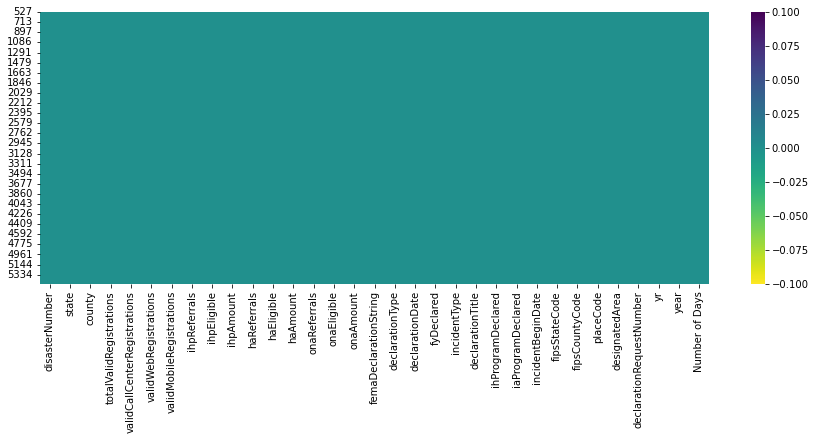

In [19]:
#Visually inspect the nulls
plt.figure(figsize = [15,5])
sns.heatmap(df_fema.isnull(), cmap = 'viridis_r');

In [20]:
#Create a GEOID column to make joining easier in th next step
df_fema['GEOID'] = df_fema['fipsStateCode'] + df_fema['fipsCountyCode'] 

df_fema.reset_index(inplace = True, drop = True)

In [21]:
df_gaz['yr'] = df_gaz['year'].astype(str)
df_fema['yr'] = df_fema['yr'].astype(str).str.split('.',expand = True)[0]
df_gaz.drop('year', axis = 1, inplace = True)

In [22]:
#Join the FEMA data and the gazateer Data
df_fema = pd.merge(df_fema,df_gaz 
                   ,on       = ['GEOID','yr']  
                   ,how      = 'left'
                   ,suffixes = ['_S','_G'])
df_fema.head()

,disasterNumber,state,county,totalValidRegistrations,validCallCenterRegistrations,validWebRegistrations,validMobileRegistrations,ihpReferrals,ihpEligible,ihpAmount,...,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,st_cd,Fips_county
0,4168,WA,Sauk-Suiattle Indian Reservation,11,10,1,0,8,6,20357.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4168,WA,Snohomish (County),1010,792,198,20,941,589,2071099.63,...,1529222.0,Snohomish County,5.405956e+09,282423390.0,2087.251,109.044,48.054913,-121.766412,53,061
2,4174,AR,Faulkner (County),1084,815,204,65,911,268,2669493.44,...,66852.0,Faulkner County,1.678022e+09,41920337.0,647.888,16.186,35.146343,-92.324646,05,045
3,4174,AR,Pulaski (County),99,67,26,6,93,16,117235.14,...,69177.0,Pulaski County,1.967208e+09,124610525.0,759.543,48.112,34.773988,-92.316515,05,119
4,4174,AR,Randolph (County),75,69,5,1,54,30,92343.14,...,69178.0,Randolph County,1.689276e+09,9858841.0,652.233,3.807,36.341298,-91.028441,05,121


# Dropping Null Vaues:
> In some instances, FEMA works with units of government that do not have corresponding Census Values. Therefore, the values for these units of government were dropped.

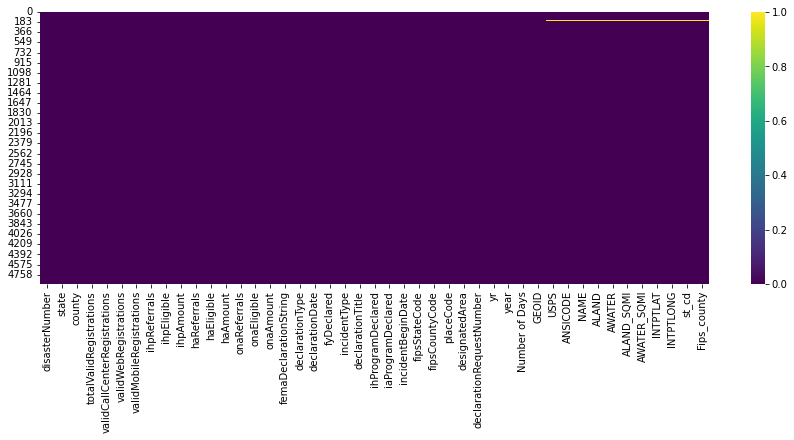

In [23]:
#Visually inspect the nulls
plt.figure(figsize = [15,5])
sns.heatmap(df_fema.isnull(), cmap = 'viridis');

In [24]:
#Convert year to a string and rename the year column for a later join
df_fema.yr = df_fema.yr.astype(str)
df_fema.rename(columns = {'year_S':'year'}, inplace = True)

# Subdivide conus and oconus
df_oConus = df_fema[df_fema['Fips_county'].isnull()].reset_index(drop = True)
df_fema = df_fema[~df_fema['Fips_county'].isnull()].reset_index(drop = True)


'''
df_oConus is a mix of island territories (excluding Puerto Rico) and First Nations. 
They Include:
   'St. John (Island) (County-equivalent)',
   'St. Thomas (Island) (County-equivalent)',
   'St. Croix (Island) (County-equivalent)',
   'Big Cypress Indian Reservation', 'Brighton Indian Reservation',
   'Fort Pierce Indian Reservation', 'Hollywood Indian Reservation',
   'Immokalee Indian Reservation', 'Tampa Reservation',
   'Eastern (District)', "Manu'a (District)",
   'Rose Island (Island) (County-equivalent)',
   'Swains Island (Island) (County-equivalent)', 'Western (District)',
   'Rota (Municipality)', 'Saipan (Municipality)',
   'Tinian (Municipality)', 'Santee Indian Reservation',
   'Oglala Lakota (County)', 'Guam (County-equivalent)',
   'Northern Mariana Islands (County-equivalent)', 'Bedford',
   'Mississippi Choctaw Indian Reservation',
   'Valdez-Cordova (Census Area)', 'Wade Hampton (Census Area)',
   'Mashantucket Pequot Indian Reservation', 'Mohegan Trust Lands',
   'Lummi Indian Reservation', 'Nooksack Indian Reservation',
   'Quileute Indian Reservation',
   'Salt River Pima-Maricopa Indian Community',
   'Kashunamiut Regional Educational Attendance Area',
   'Seminole Indian Trust Lands'
'''

df_fema.head()

,disasterNumber,state,county,totalValidRegistrations,validCallCenterRegistrations,validWebRegistrations,validMobileRegistrations,ihpReferrals,ihpEligible,ihpAmount,...,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,st_cd,Fips_county
0,4168,WA,Snohomish (County),1010,792,198,20,941,589,2071099.63,...,1529222.0,Snohomish County,5.405956e+09,282423390.0,2087.251,109.044,48.054913,-121.766412,53,061
1,4174,AR,Faulkner (County),1084,815,204,65,911,268,2669493.44,...,66852.0,Faulkner County,1.678022e+09,41920337.0,647.888,16.186,35.146343,-92.324646,05,045
2,4174,AR,Pulaski (County),99,67,26,6,93,16,117235.14,...,69177.0,Pulaski County,1.967208e+09,124610525.0,759.543,48.112,34.773988,-92.316515,05,119
3,4174,AR,Randolph (County),75,69,5,1,54,30,92343.14,...,69178.0,Randolph County,1.689276e+09,9858841.0,652.233,3.807,36.341298,-91.028441,05,121
4,4174,AR,White (County),99,73,20,6,86,27,162060.52,...,69906.0,White County,2.680818e+09,18326633.0,1035.070,7.076,35.254722,-91.753158,05,145


# Dropping Columns:
>These columns were not specifically related to the questions requested and therefore dropped. 

In [25]:
#Drop the columns
df_fema.drop(['disasterNumber','validCallCenterRegistrations','validWebRegistrations'
              ,'validMobileRegistrations', 'ihpReferrals','ihpEligible','ihpAmount'
              ,'haReferrals', 'haEligible', 'haAmount','onaReferrals','onaEligible'
              ,'onaAmount', 'femaDeclarationString','declarationType','declarationDate'
              ,'fyDeclared','declarationTitle', 'ihProgramDeclared','fipsCountyCode'
              ,'iaProgramDeclared','incidentBeginDate', 'fipsStateCode'
              ,'placeCode','designatedArea', 'declarationRequestNumber'
              ,'ANSICODE','NAME','USPS'
             ],axis = 1, inplace = True)

In [26]:
# Rename the state codes and the fips codes
dfcensus.rename(columns  = {'state':'st_cd'
                          ,'county':'Fips_county'}
                ,inplace = True
               )

#Cenusus additional attributes
dfcensus.st_cd = dfcensus.st_cd.astype(str).str.split('.', expand = True)[0]
dfcensus.Fips_county = dfcensus.Fips_county.astype(str).str.split('.', expand = True)[0]
dfcensus['year'] = dfcensus['year'].astype(int).astype(str)

## Merge the Data and Review the Output for Nulls
### Dropping Null Values:
> The heatmap below shows that null values were dropped. The reason for dropping the null values is that it appears that Census does not have corresponding data for the years listed below. Therefore, it is not possible to use the years for which there is FEMA data and not Census Data

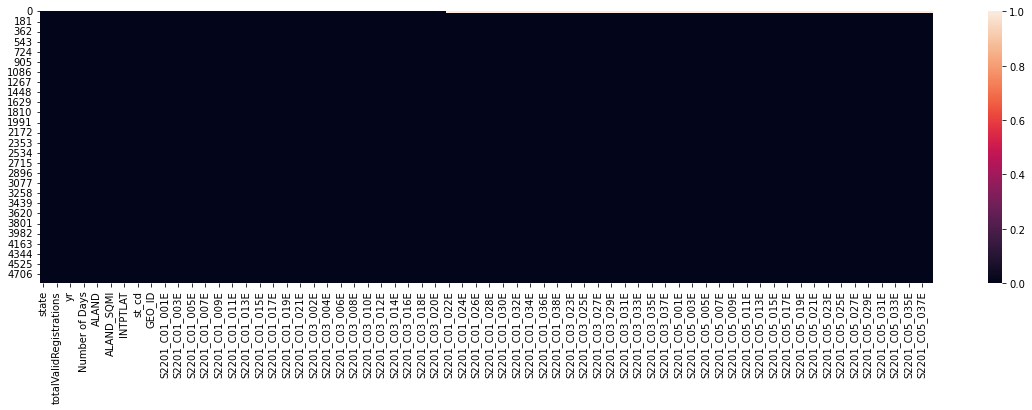

In [27]:
#Merge the fema data and the census data
df= pd.merge(df_fema, dfcensus
             , on  = ['year','Fips_county','st_cd','GEOID']
             , how = 'left'
            ).reset_index(drop = True)

#Investigate the output to determine if there are null values
plt.figure(figsize = [20,5])
sns.heatmap(df.isnull());

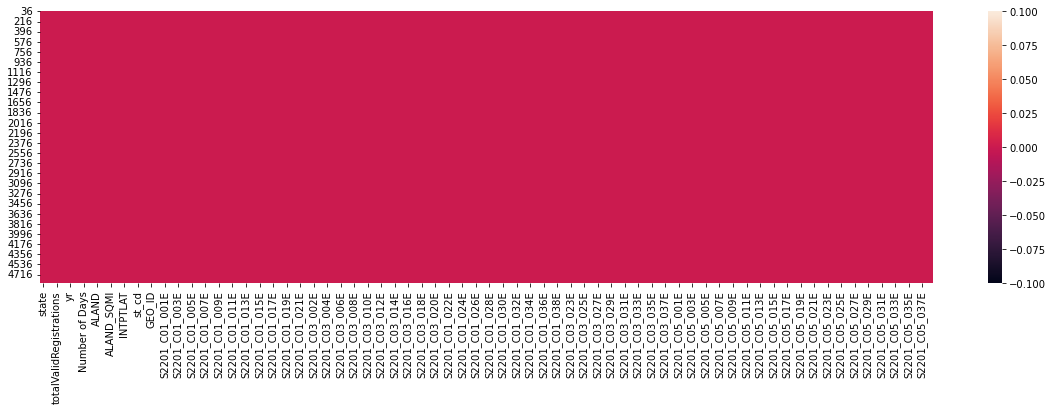

In [28]:
#The null values identified in the above are dropped
df.dropna(axis = 0, inplace = True)
#Output re-investigated
plt.figure(figsize = [20,5])
sns.heatmap(df.isnull());

In [29]:
#The data appears to be highly skewed
df.skew()

totalValidRegistrations    22.485118
yr                         -1.500429
year                       -1.703669
Number of Days             -0.862180
GEOID                       0.280180
                             ...    
S2201_C05_034E            -50.601432
S2201_C05_035E             12.231800
S2201_C05_036E             10.387973
S2201_C05_037E             12.467446
S2201_C05_038E             12.309120
Length: 127, dtype: float64

## Look at the Output after a Log Transformation: Full Dataset

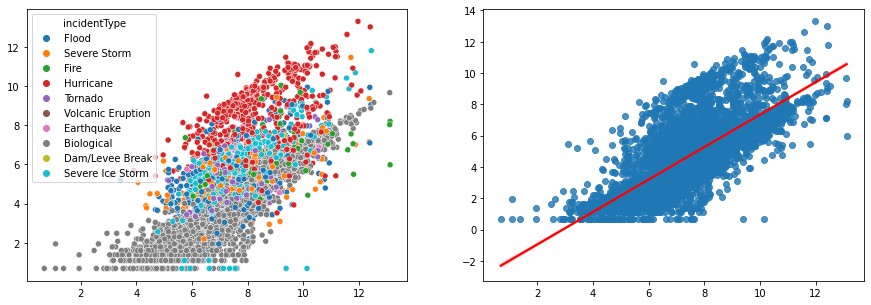

In [30]:
plt.figure(figsize = [15,5])
plt.title('Log Transformed Data')
plt.xlabel('Log Transformed S2201_C01_007E')
plt.ylabel('Log Transformed Valid Registrations')
plt.subplot(1,2,1)
sns.scatterplot(np.log([x+1 for x in df['S2201_C01_007E']])
               ,np.log([x+1 for x in df['totalValidRegistrations']])
               ,hue = df['incidentType']#.astype('category').cat.codes
               )
plt.subplot(1,2,2)
sns.regplot(np.log([x+1 for x in df['S2201_C01_007E']])
           ,np.log([x+1 for x in df['totalValidRegistrations']])
           ,line_kws = {'color':'red'}
            );

## Filter the Dataset for Hurricanes: Create Subdivisions within Hurricane Incident Type
>This section is used to support the idea that creating subdivisions of the data may lead to reduced variance. In all but the bottom quintile, the communityImpact Variable improves the model's performance

In [31]:
#Filter the dataset for only Hurricanes
df_hurricane = df[df['incidentType']=='Hurricane'].reset_index(drop = True)

# Subdivide the disasters by the number of registrations into 5 groups
df_hurricane['disasterSize']= pd.qcut(df_hurricane.loc[:,'totalValidRegistrations']
                            ,5
                            ,labels =[ "Very Small","Small"
                                     , "Medium", "Large"
                                     , "Very Large"
                                     ]
                           )
# Subdivide the disasters into 5 groups using the ratio of the number of registrations by househould
df_hurricane['communityImpact']= pd.qcut(df_hurricane.loc[:,'totalValidRegistrations']\
                                       /df_hurricane.loc[:,'S2201_C01_001E']#Number of Households
                            ,5
                            ,labels =["Very Low","Low"
                                     , "Medium", "Large"
                                     , "Very Large"
                                     ]
                           )


df_hurricane.head()

,state,county,totalValidRegistrations,incidentType,yr,year,Number of Days,GEOID,ALAND,AWATER,...,S2201_C05_031E,S2201_C05_032E,S2201_C05_033E,S2201_C05_034E,S2201_C05_035E,S2201_C05_036E,S2201_C05_037E,S2201_C05_038E,disasterSize,communityImpact
0,FL,Citrus (County),984,Hurricane,2016,2016,28,12017,1.507099e+09,495590953.0,...,358.0,1702.0,48856.0,42994.0,32681.0,13725.0,10030.0,8926.0,Small,Very Low
1,FL,Dixie (County),387,Hurricane,2016,2016,28,12029,1.826212e+09,410631095.0,...,90.0,146.0,4239.0,39565.0,2938.0,868.0,921.0,1149.0,Very Small,Low
2,FL,Hernando (County),332,Hurricane,2016,2016,28,12053,1.224612e+09,300943525.0,...,726.0,5094.0,52122.0,45490.0,39889.0,14626.0,11430.0,13833.0,Very Small,Very Low
3,FL,Hillsborough (County),224,Hurricane,2016,2016,28,12057,2.642601e+09,635592710.0,...,8652.0,78553.0,259869.0,59510.0,257230.0,34515.0,84438.0,138277.0,Very Small,Very Low
4,FL,Leon (County),1413,Hurricane,2016,2016,28,12073,1.727172e+09,90453994.0,...,1641.0,4976.0,64704.0,53763.0,51912.0,5947.0,16289.0,29676.0,Small,Very Low


In [32]:
df_hurricane.columns

Index(['state', 'county', 'totalValidRegistrations', 'incidentType', 'yr',
       'year', 'Number of Days', 'GEOID', 'ALAND', 'AWATER',
       ...
       'S2201_C05_031E', 'S2201_C05_032E', 'S2201_C05_033E', 'S2201_C05_034E',
       'S2201_C05_035E', 'S2201_C05_036E', 'S2201_C05_037E', 'S2201_C05_038E',
       'disasterSize', 'communityImpact'],
      dtype='object', length=134)

# 3. Data Preparation: 
* Inspect the Relationship between Female Householders and Registrations:
> While the overall relationship is fairly weak, the subdivided relationship appears to be quite strong in almost all subdivisions; only the very small applications to registration ratio appears to have a moderate relationship

0.43069381996042216


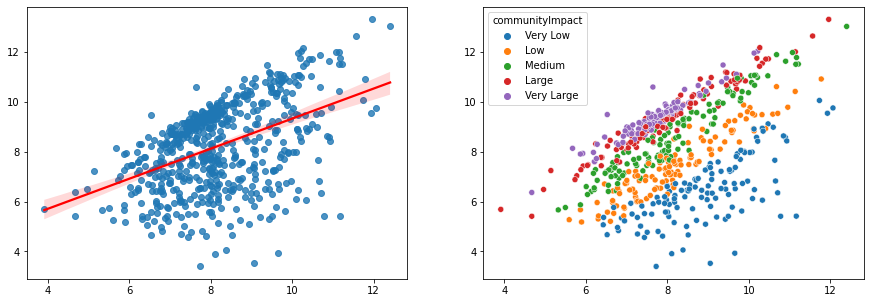

In [33]:
plt.figure(figsize = [15,5])
plt.title('Log Transformed Data')
plt.xlabel('S2201_C01_007E')
plt.subplot(1,2,2)
#Log transformation of Female Householder  
scatter_1 = sns.scatterplot(np.log([x+1 for x in df_hurricane['S2201_C01_007E']]) #Female householder,
                           ,np.log([x+1 for x in df_hurricane['totalValidRegistrations']])
                           ,hue = df_hurricane['communityImpact']#.astype('category').cat.codes
                           )

plt.subplot(1,2,1)
S_corr = df_hurricane[['totalValidRegistrations','S2201_C01_007E']].corr(method = 'spearman').values[0][1]
print(S_corr)
scatter_2 = sns.regplot(np.log([x+1 for x in df_hurricane['S2201_C01_007E']])
                        ,np.log([x+1 for x in df_hurricane['totalValidRegistrations']])
                        ,line_kws = {'color':'red'}
                        )



### S2201_C01_002E: Census Variable for People over 60
>Estimate!!Total!!Households!!With one or more people in the household 60 years and over

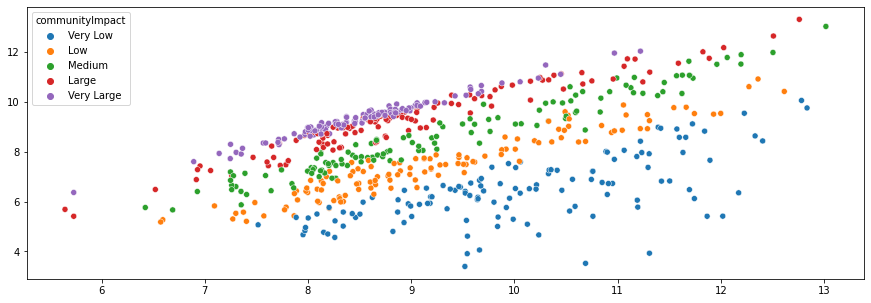

In [34]:
#This is an expanded version of the chart on the right. It appears very linear
plt.figure(figsize = [15,5])
sns.scatterplot(np.log([x+1 for x in df_hurricane['S2201_C01_002E']])
                ,np.log([x+1 for x in df_hurricane['totalValidRegistrations']])
                ,hue = df_hurricane['communityImpact']#.astype('category').cat.codes
                );

## Regplot: Question 2
>How might we subdivide the data to reduce the variance?: **Create a ratio of Valid Registrations to Households**

### S2201_C01_002E: Elderly

Very Low Disaster: Spearman Correlation 0.65
Low Disaster: Spearman Correlation 0.94
Medium Disaster: Spearman Correlation 0.97
Large Disaster: Spearman Correlation 0.95
Very Large Disaster: Spearman Correlation 0.98


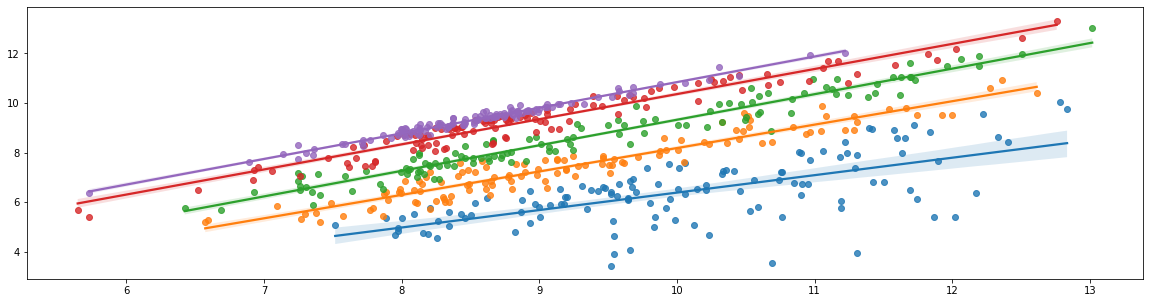

In [35]:
plt.figure(figsize = [20,5])
#Elderly
community_impact('S2201_C01_002E')

### S2201_C01_007E: Female Head of Household

Very Low Disaster: Spearman Correlation 0.67
Low Disaster: Spearman Correlation 0.92
Medium Disaster: Spearman Correlation 0.96
Large Disaster: Spearman Correlation 0.97
Very Large Disaster: Spearman Correlation 0.93


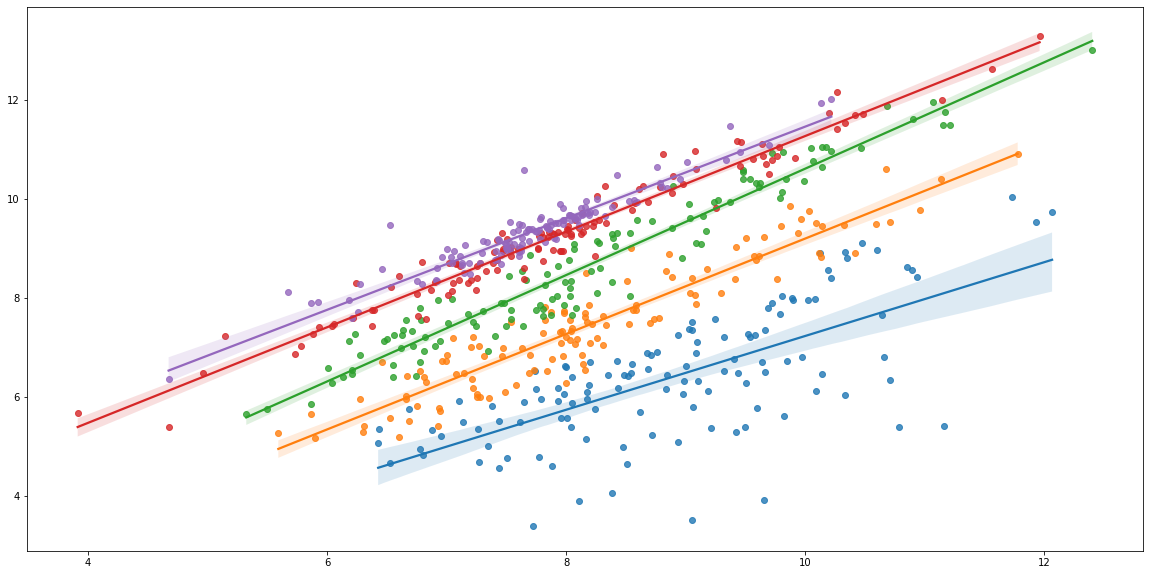

In [36]:
plt.figure(figsize = [20,10])
#Female Head of Household
community_impact('S2201_C01_007E')

### S2201_C01_023E: Disability

Very Low Disaster: Spearman Correlation 0.67
Low Disaster: Spearman Correlation 0.94
Medium Disaster: Spearman Correlation 0.97
Large Disaster: Spearman Correlation 0.94
Very Large Disaster: Spearman Correlation 0.88


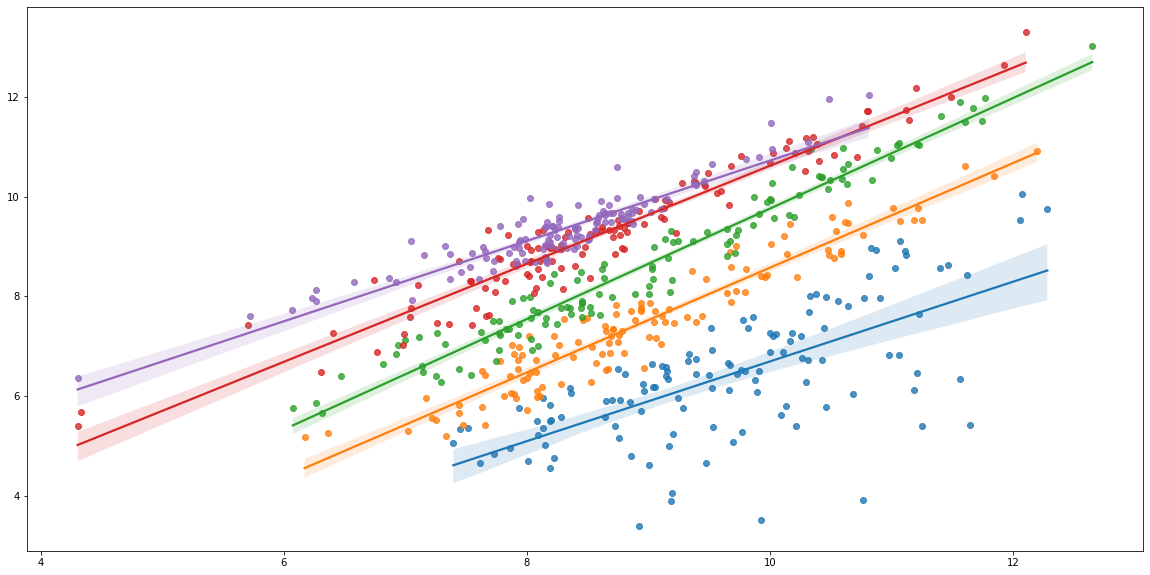

In [37]:
plt.figure(figsize = [20,10])
community_impact('S2201_C01_023E')

### S2201_C03_001E: Supplemental Nutrition Assistance Program

Very Low Disaster: Spearman Correlation 0.64
Low Disaster: Spearman Correlation 0.85
Medium Disaster: Spearman Correlation 0.95
Large Disaster: Spearman Correlation 0.94
Very Large Disaster: Spearman Correlation 0.85


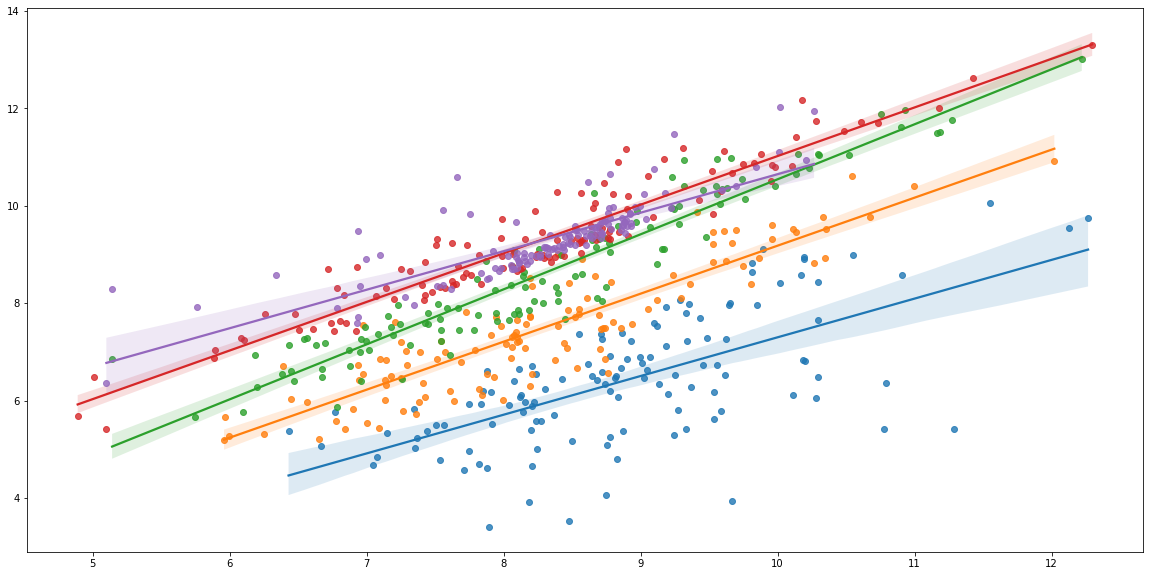

In [39]:
plt.figure(figsize = [20,10])
community_impact('S2201_C03_001E')

## For Each of the Above, the Very Small Disaster had an R^2 of under 70%. 
> Investigated all of the elements in the Table to see if a better result could be identified

totalValidRegistrations Disaster: Spearman Correlation 1.00


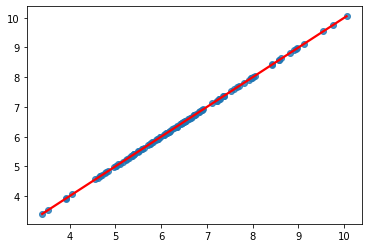

Number of Days Disaster: Spearman Correlation -0.14


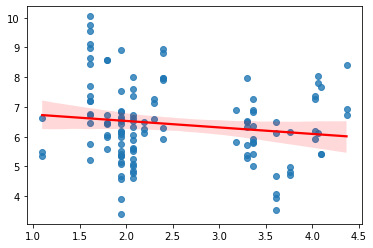

ALAND Disaster: Spearman Correlation 0.15


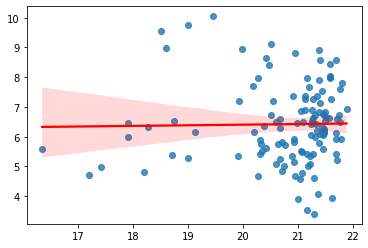

AWATER Disaster: Spearman Correlation 0.19


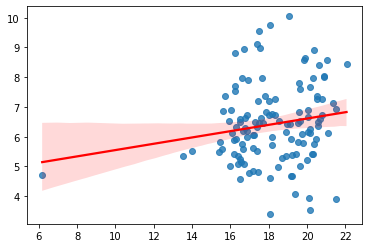

ALAND_SQMI Disaster: Spearman Correlation 0.15


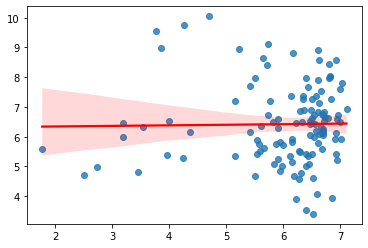

AWATER_SQMI Disaster: Spearman Correlation 0.19


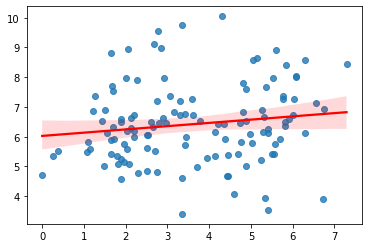

INTPTLAT Disaster: Spearman Correlation 0.22


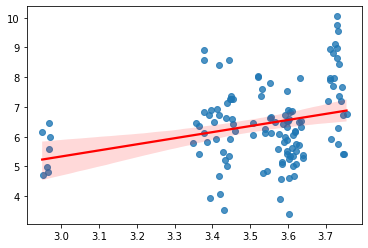

INTPTLONG Disaster: Spearman Correlation 0.09


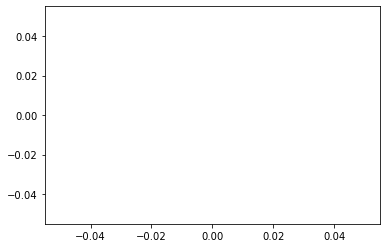

S2201_C01_001E Disaster: Spearman Correlation 0.66


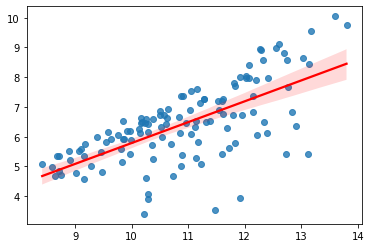

S2201_C01_002E Disaster: Spearman Correlation 0.65


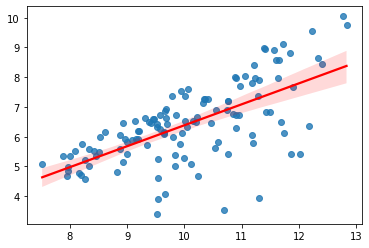

S2201_C01_003E Disaster: Spearman Correlation 0.67


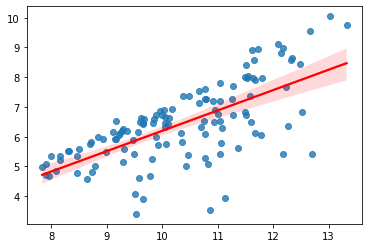

S2201_C01_004E Disaster: Spearman Correlation 0.66


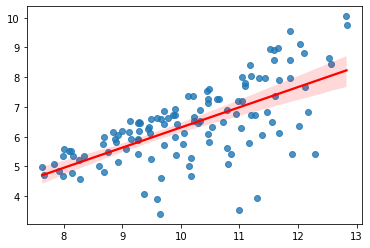

S2201_C01_005E Disaster: Spearman Correlation 0.67


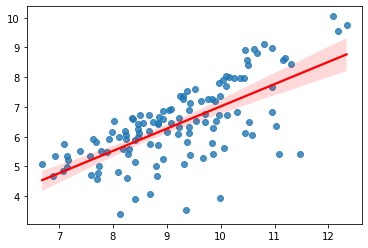

S2201_C01_006E Disaster: Spearman Correlation 0.67


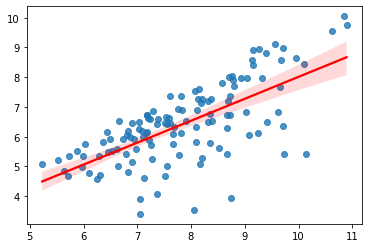

S2201_C01_007E Disaster: Spearman Correlation 0.67


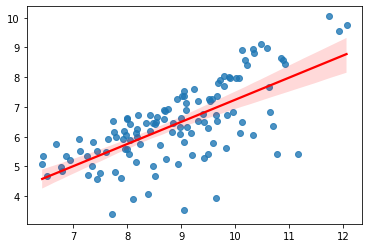

S2201_C01_008E Disaster: Spearman Correlation 0.66


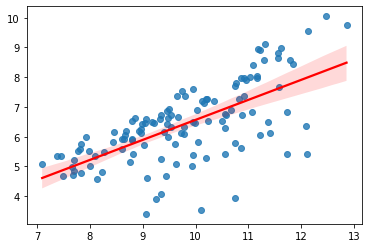

S2201_C01_009E Disaster: Spearman Correlation 0.67


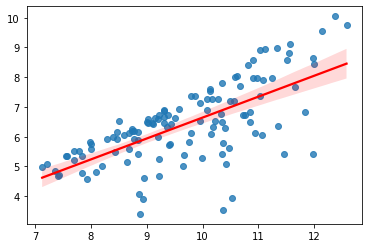

S2201_C01_010E Disaster: Spearman Correlation 0.67


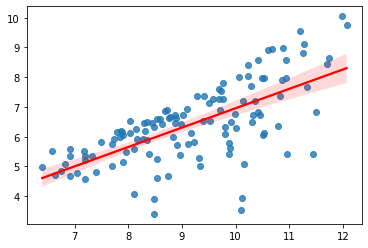

S2201_C01_011E Disaster: Spearman Correlation 0.67


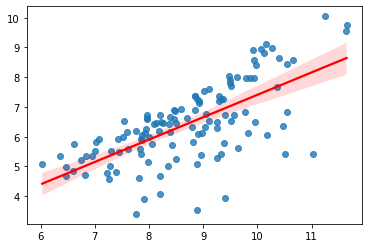

S2201_C01_012E Disaster: Spearman Correlation 0.66


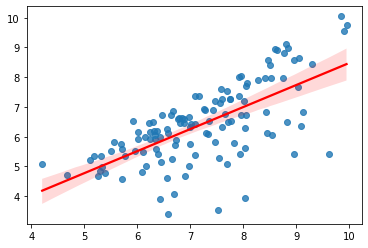

S2201_C01_013E Disaster: Spearman Correlation 0.67


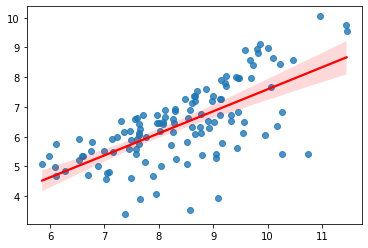

S2201_C01_014E Disaster: Spearman Correlation 0.60


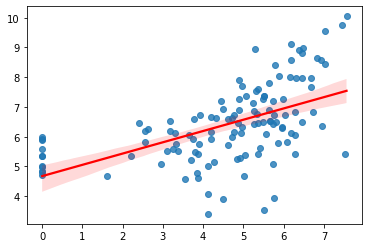

S2201_C01_015E Disaster: Spearman Correlation 0.65


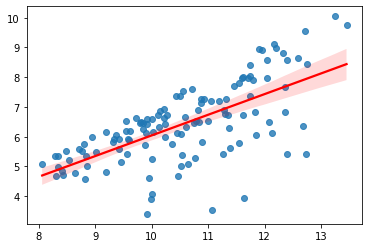

S2201_C01_016E Disaster: Spearman Correlation 0.65


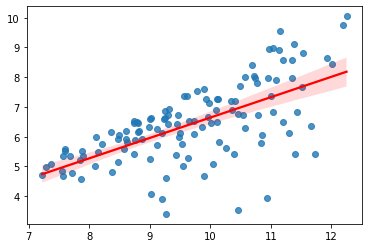

S2201_C01_017E Disaster: Spearman Correlation 0.67


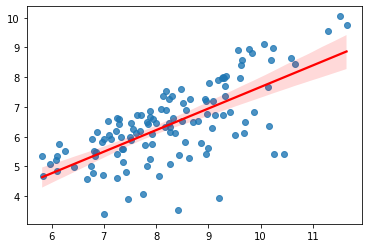

S2201_C01_018E Disaster: Spearman Correlation 0.65


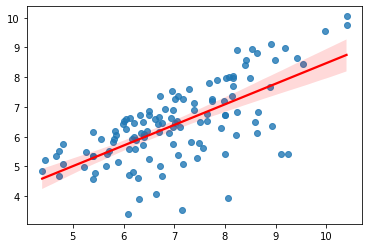

S2201_C01_019E Disaster: Spearman Correlation 0.67


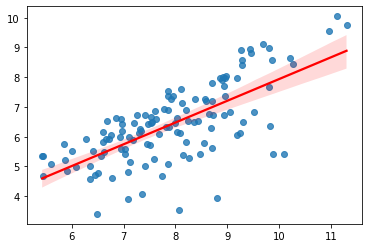

S2201_C01_020E Disaster: Spearman Correlation 0.66


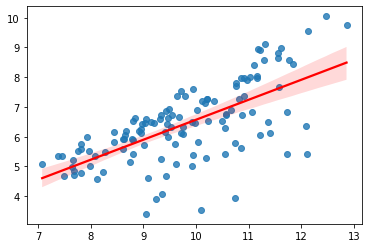

S2201_C01_021E Disaster: Spearman Correlation 0.66


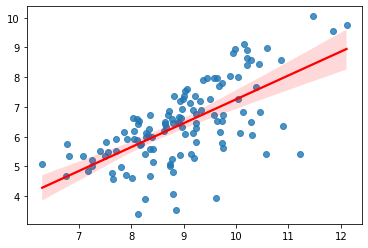

S2201_C03_001E Disaster: Spearman Correlation 0.64


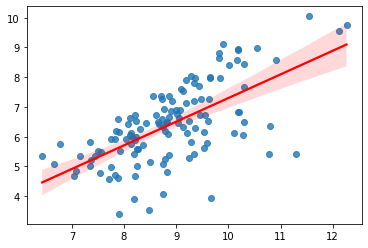

S2201_C03_002E Disaster: Spearman Correlation 0.62


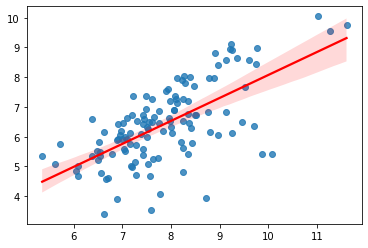

S2201_C03_003E Disaster: Spearman Correlation 0.63


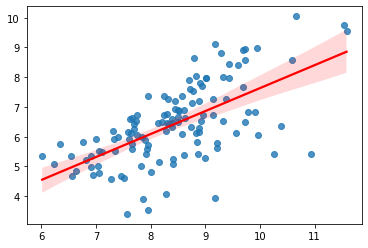

S2201_C03_004E Disaster: Spearman Correlation 0.63


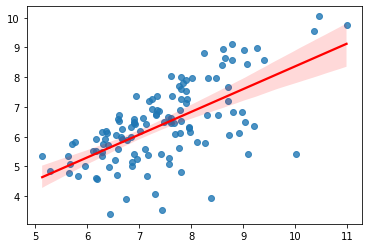

S2201_C03_005E Disaster: Spearman Correlation 0.63


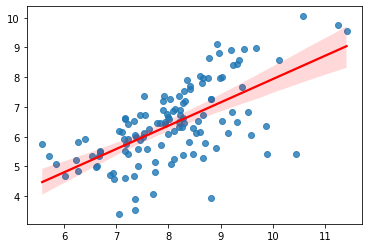

S2201_C03_006E Disaster: Spearman Correlation 0.61


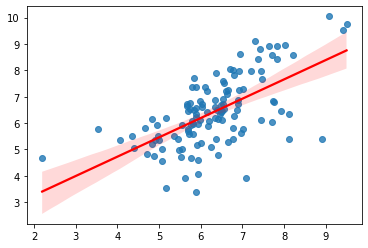

S2201_C03_007E Disaster: Spearman Correlation 0.62


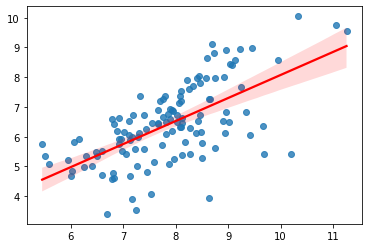

S2201_C03_008E Disaster: Spearman Correlation 0.63


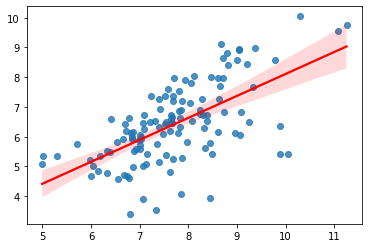

S2201_C03_009E Disaster: Spearman Correlation 0.65


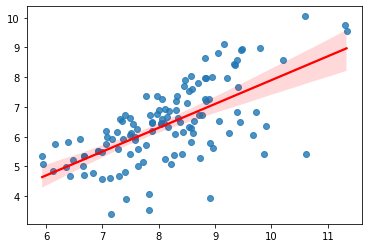

S2201_C03_010E Disaster: Spearman Correlation 0.64


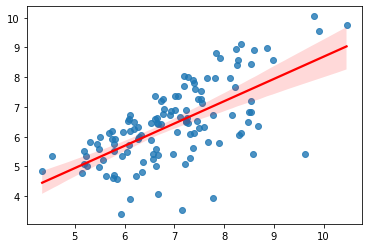

S2201_C03_011E Disaster: Spearman Correlation 0.63


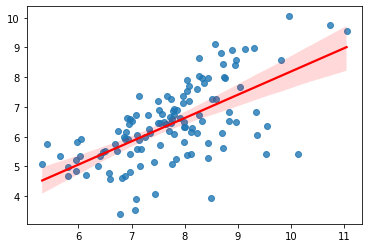

S2201_C03_012E Disaster: Spearman Correlation 0.62


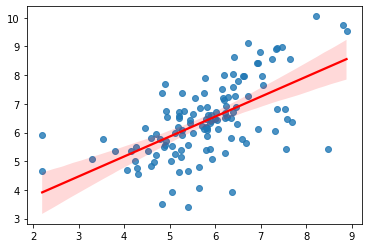

S2201_C03_013E Disaster: Spearman Correlation 0.63


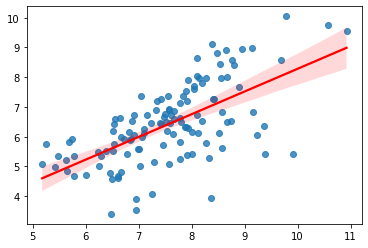

S2201_C03_014E Disaster: Spearman Correlation 0.44


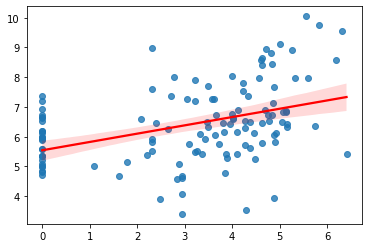

S2201_C03_015E Disaster: Spearman Correlation 0.62


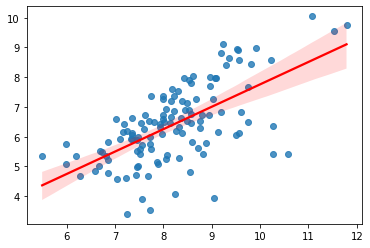

S2201_C03_016E Disaster: Spearman Correlation 0.57


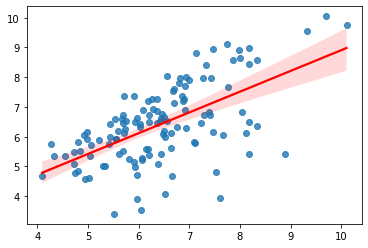

S2201_C03_017E Disaster: Spearman Correlation 0.61


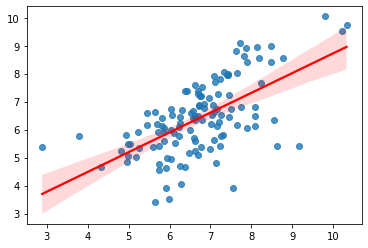

S2201_C03_018E Disaster: Spearman Correlation 0.52


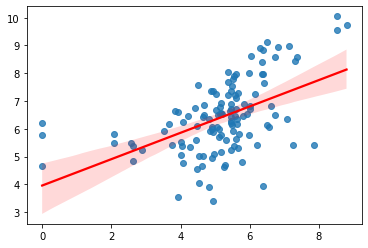

S2201_C03_019E Disaster: Spearman Correlation 0.62


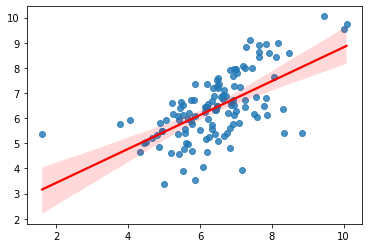

S2201_C03_020E Disaster: Spearman Correlation 0.62


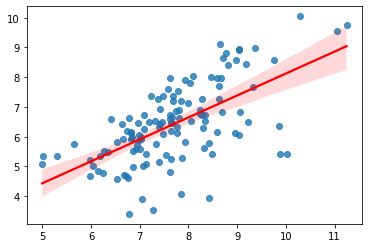

S2201_C03_021E Disaster: Spearman Correlation 0.60


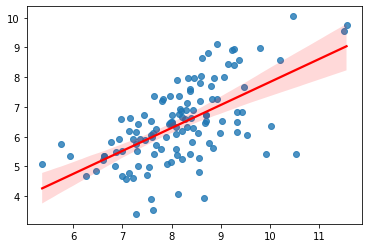

S2201_C01_022E Disaster: Spearman Correlation 0.66


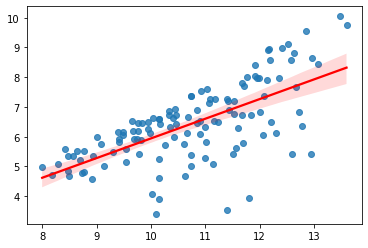

S2201_C01_023E Disaster: Spearman Correlation 0.67


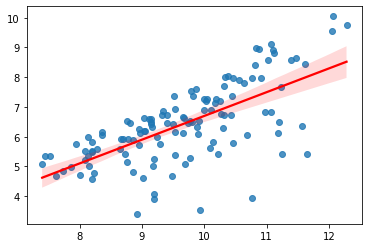

S2201_C01_024E Disaster: Spearman Correlation 0.66


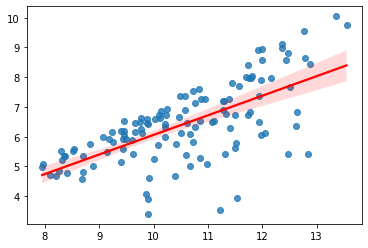

S2201_C01_025E Disaster: Spearman Correlation 0.64


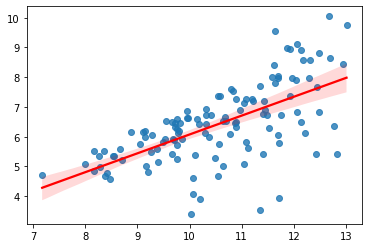

S2201_C01_026E Disaster: Spearman Correlation 0.59


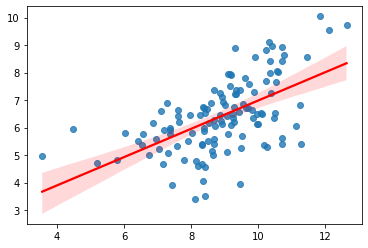

S2201_C01_027E Disaster: Spearman Correlation 0.60


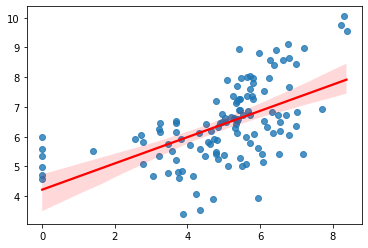

S2201_C01_028E Disaster: Spearman Correlation 0.60


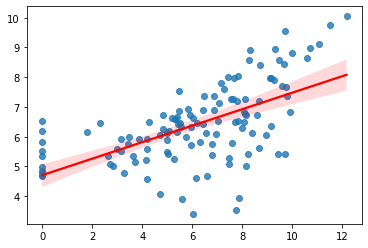

S2201_C01_029E Disaster: Spearman Correlation 0.48


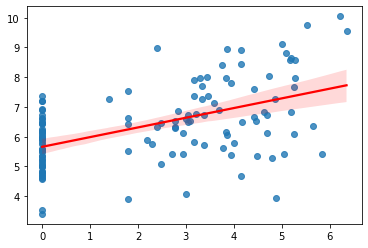

S2201_C01_030E Disaster: Spearman Correlation 0.54


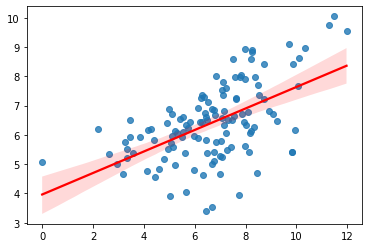

S2201_C01_031E Disaster: Spearman Correlation 0.59


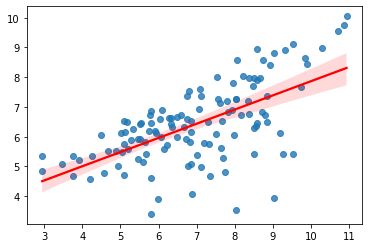

S2201_C01_032E Disaster: Spearman Correlation 0.50


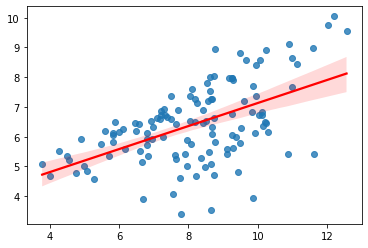

S2201_C01_033E Disaster: Spearman Correlation 0.63


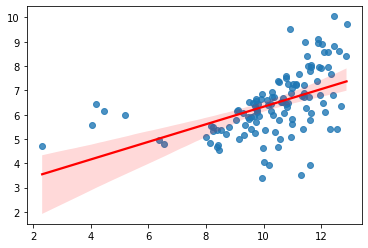

S2201_C01_034E Disaster: Spearman Correlation 0.42


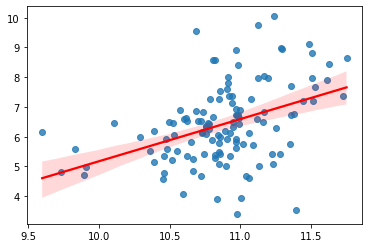

S2201_C01_035E Disaster: Spearman Correlation 0.67


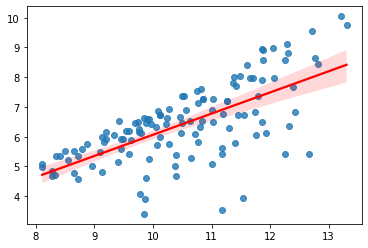

S2201_C01_036E Disaster: Spearman Correlation 0.62


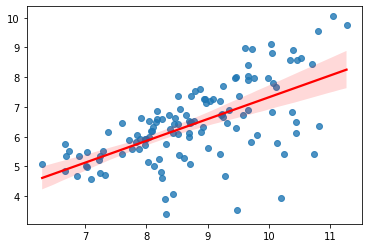

S2201_C01_037E Disaster: Spearman Correlation 0.67


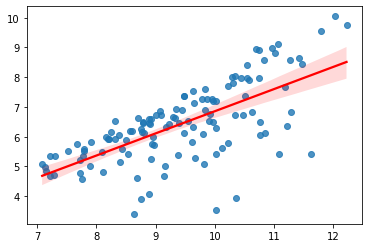

S2201_C01_038E Disaster: Spearman Correlation 0.67


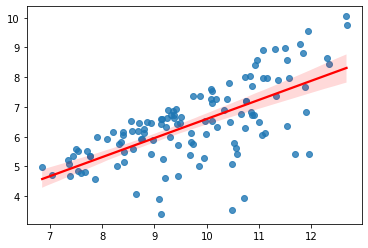

S2201_C03_022E Disaster: Spearman Correlation 0.65


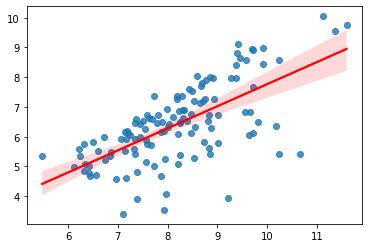

S2201_C03_023E Disaster: Spearman Correlation 0.64


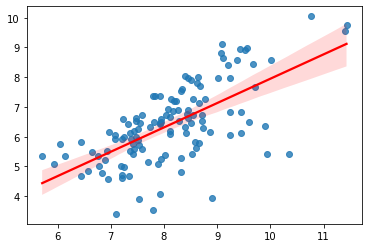

S2201_C03_024E Disaster: Spearman Correlation 0.63


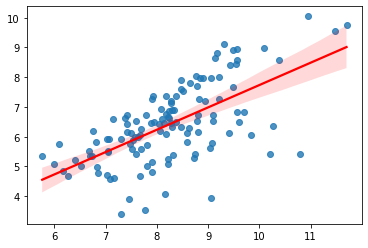

S2201_C03_025E Disaster: Spearman Correlation 0.60


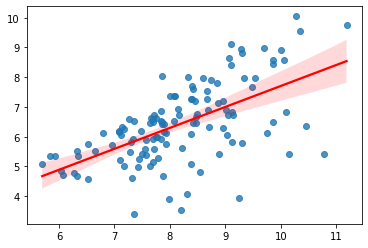

S2201_C03_026E Disaster: Spearman Correlation 0.53


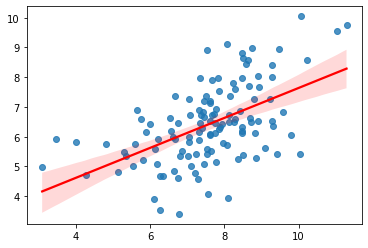

S2201_C03_027E Disaster: Spearman Correlation 0.46


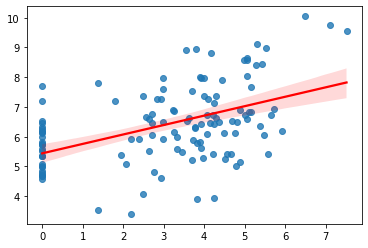

S2201_C03_028E Disaster: Spearman Correlation 0.53


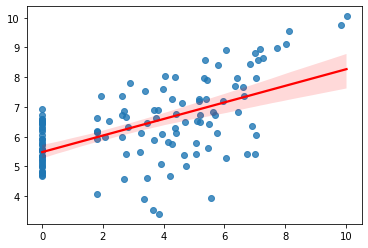

S2201_C03_029E Disaster: Spearman Correlation 0.26


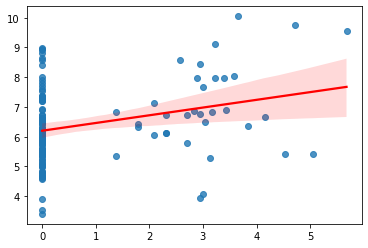

S2201_C03_030E Disaster: Spearman Correlation 0.48


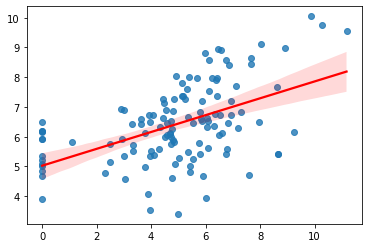

S2201_C03_031E Disaster: Spearman Correlation 0.52


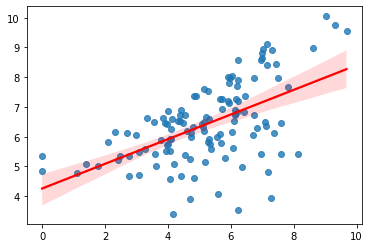

S2201_C03_032E Disaster: Spearman Correlation 0.41


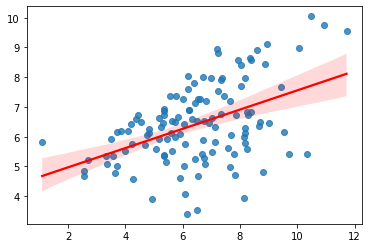

S2201_C03_033E Disaster: Spearman Correlation 0.61


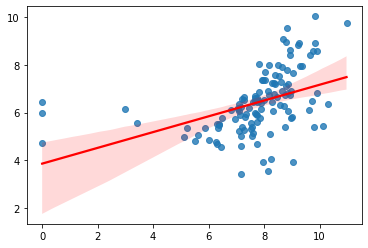

S2201_C03_034E Disaster: Spearman Correlation 0.39


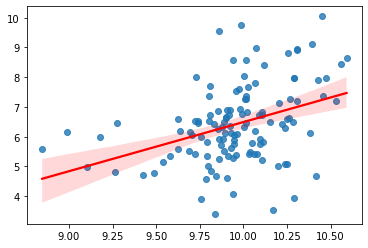

S2201_C03_035E Disaster: Spearman Correlation 0.63


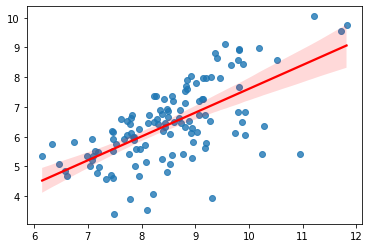

S2201_C03_036E Disaster: Spearman Correlation 0.58


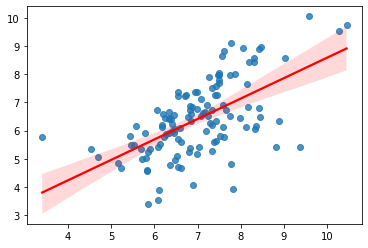

S2201_C03_037E Disaster: Spearman Correlation 0.63


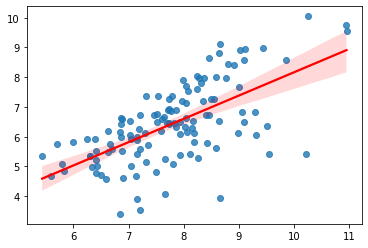

S2201_C03_038E Disaster: Spearman Correlation 0.65


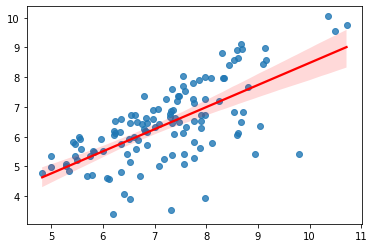

S2201_C05_001E Disaster: Spearman Correlation 0.66


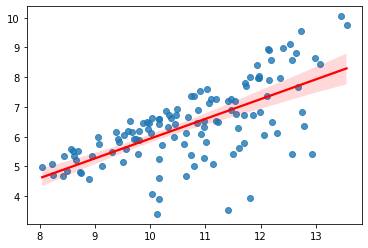

S2201_C05_002E Disaster: Spearman Correlation 0.64


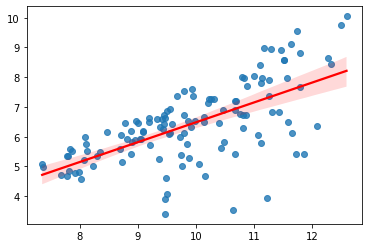

S2201_C05_003E Disaster: Spearman Correlation 0.67


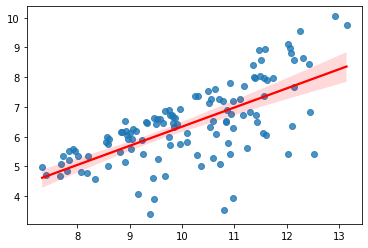

S2201_C05_004E Disaster: Spearman Correlation 0.66


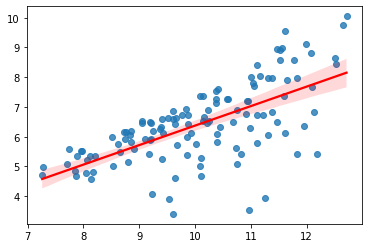

S2201_C05_005E Disaster: Spearman Correlation 0.67


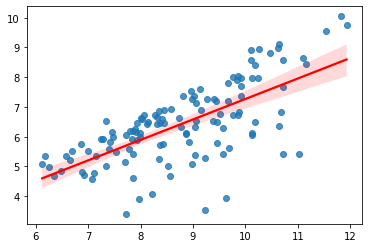

S2201_C05_006E Disaster: Spearman Correlation 0.66


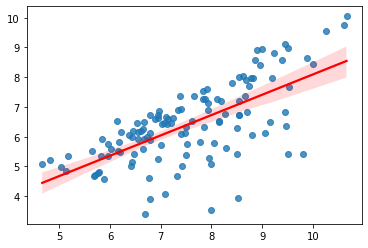

S2201_C05_007E Disaster: Spearman Correlation 0.68


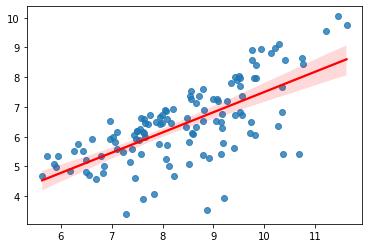

S2201_C05_008E Disaster: Spearman Correlation 0.66


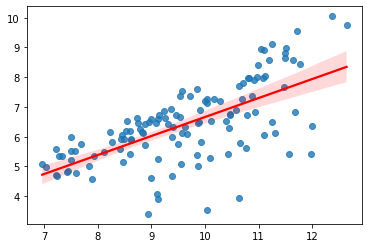

S2201_C05_009E Disaster: Spearman Correlation 0.67


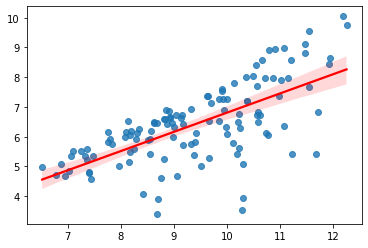

S2201_C05_010E Disaster: Spearman Correlation 0.66


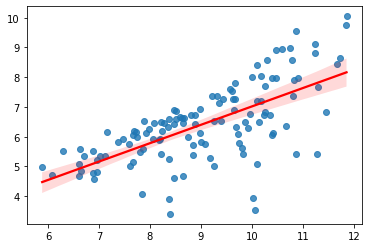

S2201_C05_011E Disaster: Spearman Correlation 0.66


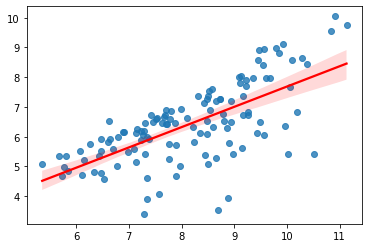

S2201_C05_012E Disaster: Spearman Correlation 0.64


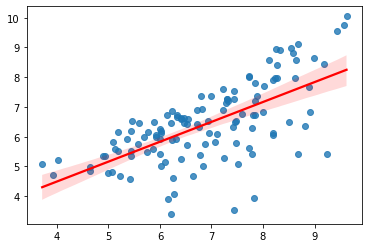

S2201_C05_013E Disaster: Spearman Correlation 0.67


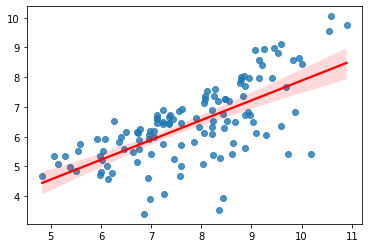

S2201_C05_014E Disaster: Spearman Correlation 0.59


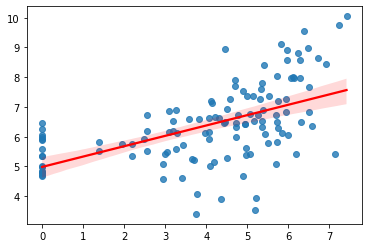

S2201_C05_015E Disaster: Spearman Correlation 0.66


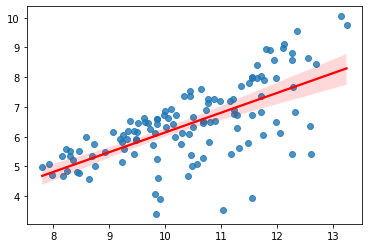

S2201_C05_016E Disaster: Spearman Correlation 0.64


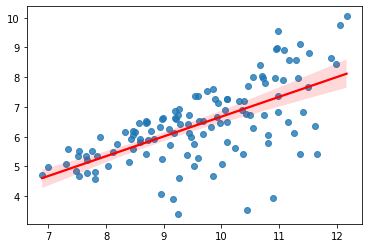

S2201_C05_017E Disaster: Spearman Correlation 0.68


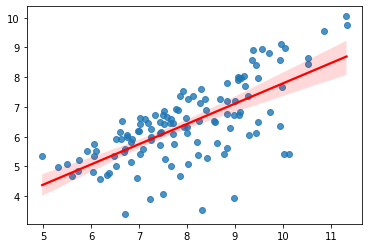

S2201_C05_018E Disaster: Spearman Correlation 0.67


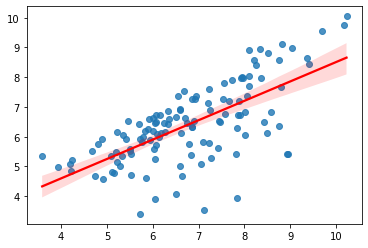

S2201_C05_019E Disaster: Spearman Correlation 0.51


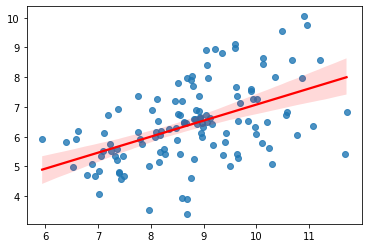

S2201_C05_020E Disaster: Spearman Correlation 0.66


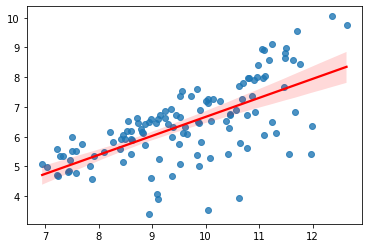

S2201_C05_021E Disaster: Spearman Correlation 0.67


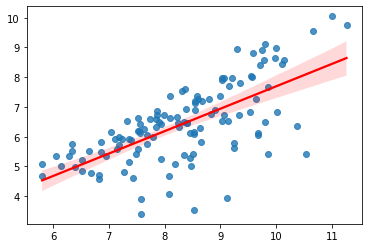

S2201_C05_022E Disaster: Spearman Correlation 0.66


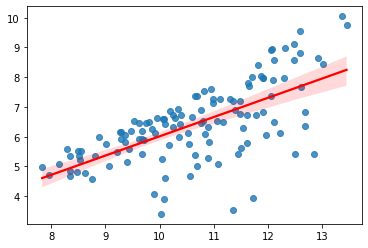

S2201_C05_023E Disaster: Spearman Correlation 0.67


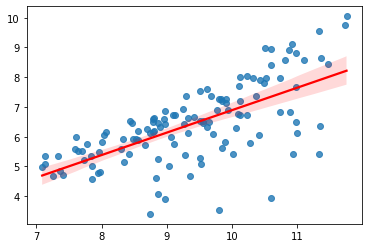

S2201_C05_024E Disaster: Spearman Correlation 0.66


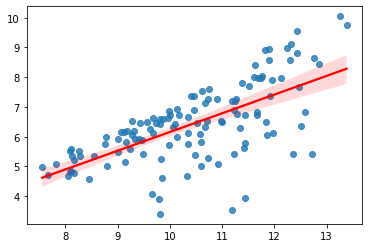

S2201_C05_025E Disaster: Spearman Correlation 0.64


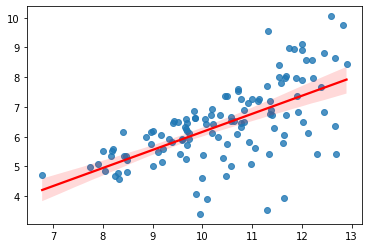

S2201_C05_026E Disaster: Spearman Correlation 0.60


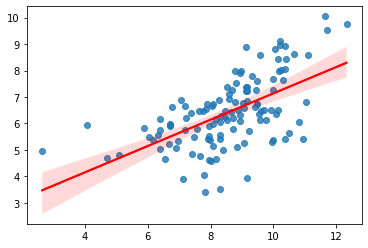

S2201_C05_027E Disaster: Spearman Correlation 0.60


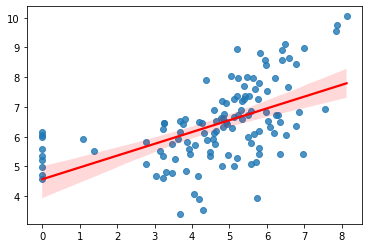

S2201_C05_028E Disaster: Spearman Correlation 0.60


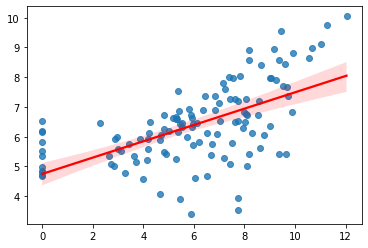

S2201_C05_029E Disaster: Spearman Correlation 0.47


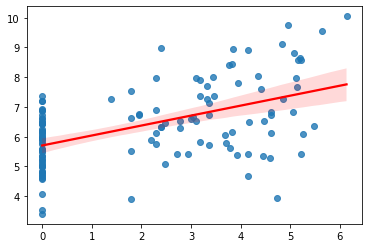

S2201_C05_030E Disaster: Spearman Correlation 0.54


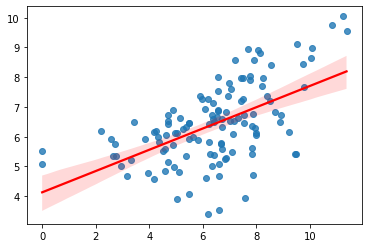

S2201_C05_031E Disaster: Spearman Correlation 0.61


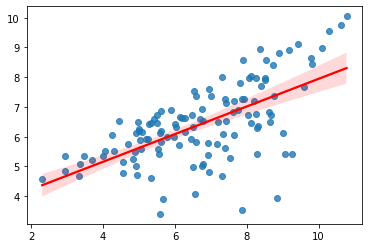

S2201_C05_032E Disaster: Spearman Correlation 0.52


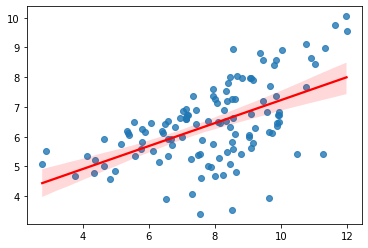

S2201_C05_033E Disaster: Spearman Correlation 0.62


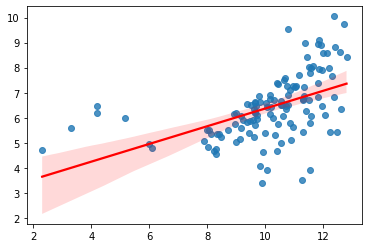

S2201_C05_034E Disaster: Spearman Correlation 0.43


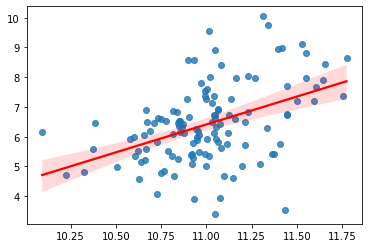

S2201_C05_035E Disaster: Spearman Correlation 0.67


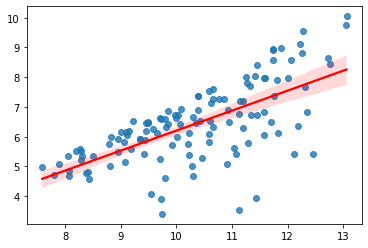

S2201_C05_036E Disaster: Spearman Correlation 0.61


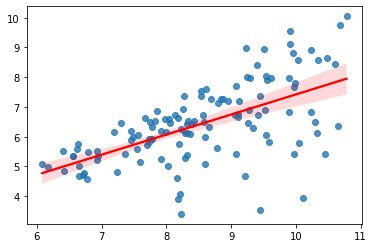

S2201_C05_037E Disaster: Spearman Correlation 0.67


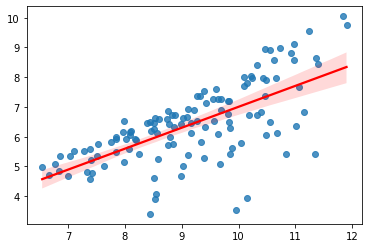

S2201_C05_038E Disaster: Spearman Correlation 0.66


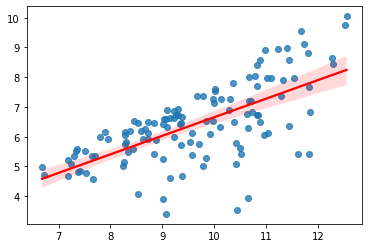

In [40]:
for column in df_hurricane.columns:
    try:
        #Focus on the very small group
        dfx = df_hurricane[df_hurricane['communityImpact'].isin(['Very Low'])]
        #Use Spearman Correlation (non-parametric) to investigate relationship. Untransformed data very Skewed:
        S_corr = dfx[['totalValidRegistrations',f'{column}']].corr(method = 'spearman').values[0][1]
        #Print the regplot with meaningful string
        print('{} Disaster: Spearman Correlation {:.2f}'.format(column,S_corr))
        #View each of the elements individually
        sns.regplot(np.log([x+1 for x in dfx[f'{column}']])
                   ,np.log([x+1 for x in dfx['totalValidRegistrations']])
                   ,line_kws={'color':'red'}
                   )
    except:
        continue
    plt.show()

## Feature Selection Begin for Features of Interest

In [42]:
#Filter for the values of interest
df_hurricane = df_hurricane[['totalValidRegistrations','S2201_C01_007E','S2201_C01_002E'
                             
                             ,'Number of Days','AWATER_SQMI','communityImpact'
                             ,'S2201_C01_001E'
                             ### REMOVED for the Below Reasons ###
                             #Better Results from other columns
                             #,'S2201_C03_001E'
                             #Residuals Normally distributed, Lasso Coef = 0
                             #,'S2201_C01_036E'
                             #Residuals not normally distributed
                             #,'S2201_C01_023E'
                            ]]


#Log-transform the data to ensure linearity
for col in df_hurricane.columns:
    if col in ['communityImpact']: #'Number of Days' is only sometimes skewed
        continue
    try:
        df_hurricane[f'{col}'] = np.log([x+1 for x in df_hurricane[f'{col}']])
    except:
        pass

df_hurricane = pd.get_dummies(df_hurricane, columns = ['communityImpact'], drop_first = True)

# Review the Data Skew
df_hurricane.skew()

totalValidRegistrations      -0.076031
S2201_C01_007E                0.367429
S2201_C01_002E                0.522915
Number of Days                1.819534
AWATER_SQMI                   0.094504
S2201_C01_001E                0.474463
communityImpact_Low           1.506260
communityImpact_Medium        1.506260
communityImpact_Large         1.506260
communityImpact_Very Large    1.506260
dtype: float64

In [43]:
df_hurricane.columns

Index(['totalValidRegistrations', 'S2201_C01_007E', 'S2201_C01_002E',
       'Number of Days', 'AWATER_SQMI', 'S2201_C01_001E',
       'communityImpact_Low', 'communityImpact_Medium',
       'communityImpact_Large', 'communityImpact_Very Large'],
      dtype='object')

## Appears to be some multi-collinearity. 
1. For S2201_C01_007E/S2201_C01_002E, we will use the Lasso Coeficients mitigate it
2. There is concern about creating a confounding variable. CommunityImpact uses households and valid Registrations
    * There does not appear to be a correlation between the dummy variables and the target or indpendent Vars
    * Therefore Moved forward with this forecast

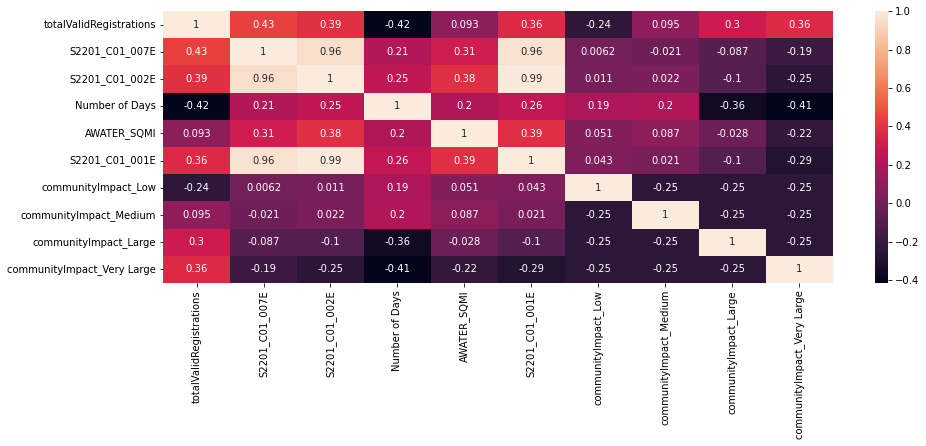

In [44]:
#Use the Heatmap to investigate for multi-collinearity
plt.figure(figsize = [15,5])
df_hurricane.skew()
sns.heatmap(df_hurricane.corr(method = 'spearman'), annot = True);


## 4. Begin Modeling

In [45]:
#Split the data to look at the P-Values
y = df_hurricane['totalValidRegistrations'].values.reshape(-1, 1)
X = df_hurricane.drop(['totalValidRegistrations','S2201_C01_001E'], axis = 1).reset_index(drop = True)


## Investigate Null Values
> No values were dropped, but before modeling this is a good check. 

<AxesSubplot:>

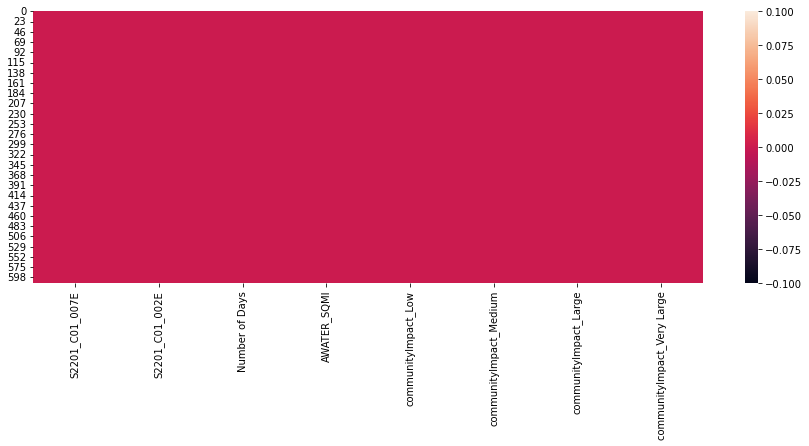

In [46]:
plt.figure(figsize= [15,5])
#The model will break if there are nulls, this is the last check for nulls before modeling
sns.heatmap(X.isnull())

In [47]:
#Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                             )
#For the visualization below, the column names are required as a list
names = X_train.columns

In [48]:
#Random Forest Regression
rfr = RFR(n_estimators = 1000, criterion = 'squared_error', random_state = 42)
rfr.fit(X_train,y_train.flatten())


RandomForestRegressor(n_estimators=1000, random_state=42)

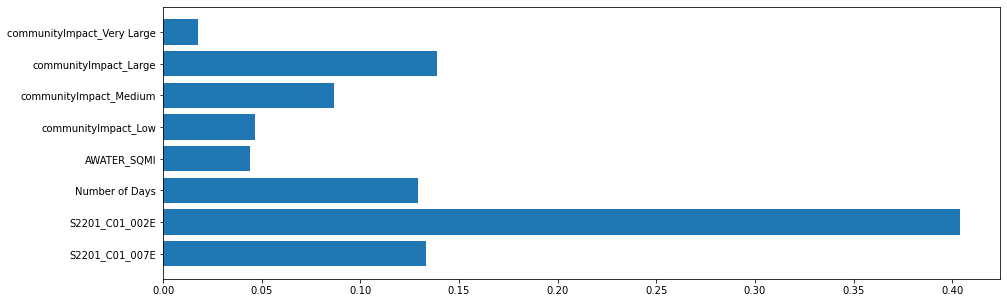

In [49]:
#Visually inspect the feature importances
plt.figure(figsize = [15,5])
plt.barh(names,rfr.feature_importances_);

In [50]:
#This is the first prediction with the available information using Random Forest
rfr_pred = rfr.predict(X_test)
rfr_score = r2_score(y_test,rfr_pred)
rfr_score

0.335342469643508

# 5. Evaluation: Begin Processing the Data:
1. Remove Values with High P-Values
2. Use the Lasso Coeficients to determine features of importance
> The idea for the below dictionary came from the following location: https://www.statology.org/statsmodels-linear-regression-p-value

## Question 3: Relationship between geographic elements and target variable
>In the below output, we see that Area of Water Square Miles has a p-value above 0.05 therefore, we exclude it and can determine that water square miles is not a good indicator. 

In [51]:
#R^2 and Adjusted R^2 are very high. Some elements have very high p-values. Must be removed/
X_train_sm = sm.add_constant(X_train)
linreg = sm.OLS( y_train,  X_train_sm ).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     204.4
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           2.88e-84
Time:                        09:04:06   Log-Likelihood:                -149.07
No. Observations:                 183   AIC:                             316.1
Df Residuals:                     174   BIC:                             345.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [52]:
#Create a dictionary to assign the P-Values to the Elements
 #While the AWATER_SQMI is part of the variables that lead to a high R^2,
 #the P-Value is also high and is therefore removed
pvalue_dict = {}
for n,cols in enumerate(X.columns):
    try:
        pvalue_dict[cols] = linreg.pvalues.loc[cols]
    except:
        continue
pvalue_dict

{'S2201_C01_007E': 5.082200066003355e-06,
 'S2201_C01_002E': 0.0011009231827358633,
 'Number of Days': 4.0446349525680114e-09,
 'AWATER_SQMI': 0.15123034157062357,
 'communityImpact_Low': 1.6529170422671766e-26,
 'communityImpact_Medium': 1.8886229487938694e-47,
 'communityImpact_Large': 3.216425903821263e-52,
 'communityImpact_Very Large': 5.953654624537808e-17}

In [53]:
#Create a dataFrame that removes any element with a P-Value greater than 0.05
df_pvalue = pd.DataFrame()
column=[]
p_value=[]
for key ,value in pvalue_dict.items():
    if value >0.05:
        pass
    else:
        col = pd.Series(key)
        val = pd.Series(value)
        column.append(col)
        p_value.append(val)
        
df_pvalue['ColumnName'] = pd.Series(column)
df_pvalue['p_value'] = pd.Series(p_value)
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].astype(str).str.lstrip(' ')
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].str.split('\n', expand = True)[0]
df_pvalue['ColumnName']= df_pvalue['ColumnName'].str.split('0  ', expand = True)[1]
columns =list(df_pvalue['ColumnName'].str.strip(' '))

#Filter the columns for the X Variable using the output from the above transformation
X = X[columns]

#Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=1111
                                                 , shuffle=False,# stratify=True
                                                )
#Again use the Names to create a list of columns for the Lasso Visualization
names = X_train.columns
names

Index(['S2201_C01_007E', 'S2201_C01_002E', 'Number of Days',
       'communityImpact_Low', 'communityImpact_Medium',
       'communityImpact_Large', 'communityImpact_Very Large'],
      dtype='object')

# Use Lasso for Feature Selection

In [54]:
#Lasso regularization for feature selection
lasso = Lasso()
lasso.fit(X_train,y_train)
#Visualize the coefficients. Unused coefficients will go to zero
lasso_coef = lasso.coef_

In [ ]:
## Question 1: Which Feature has the highest utility in a model##
            ## Answer: S2201_C01_002E ##
    ## Reasoning: Lasso Regularization Vizualization ##

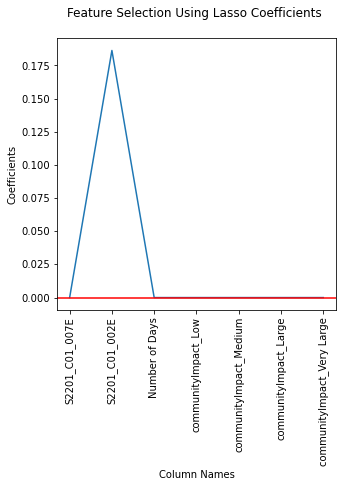

In [75]:
#Used for Feature Selection: 
 #The visualization indicates Households with sixty or greater is the best predictor variable
plt.figure(figsize = [5,5])

lasso1 = plt.plot(range(len(names)),lasso_coef)
plt.xticks(range(len(names)),names, rotation = 90)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.ylabel('Coefficients')
plt.xlabel('Column Names')
plt.title('Feature Selection Using Lasso Coefficients \n')

plt.savefig('Lasso Feature Selection.jpg')
plt.show();

In [56]:
#Reduce the number of columns to only those that are identified by Lasso with a coef>0
 #Because we know that the community impact is important to subdiving the data, 
 #only S2201 columns are removed. 
if len(lasso_coef)>1:
    data = zip(names,lasso_coef)
    data = pd.DataFrame(data)
    column_drop = data[data[0].str.contains('S2201')& (data[1]==0)][0].values
    X = X.drop(column_drop, axis = 1)
    print('complete Lasso: ','There are {} columns'.format(len(lasso_coef)))
else:
    X=X
    print('incomplete Lasso: ','There are {} columns'.format(len(lasso_coef)))
# # X.drop('S2201_C01_007E',axis =1, inplace = True)
X.columns


complete Lasso There are 7 columns


Index(['S2201_C01_002E', 'Number of Days', 'communityImpact_Low',
       'communityImpact_Medium', 'communityImpact_Large',
       'communityImpact_Very Large'],
      dtype='object')

# Evaluate the Final Models

In [57]:
#Split the data into test and train
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                                )

In [58]:
# Use stats models api to check the P-Value and the adjusted R^2
# See how close the R^2 and adjusted R^2 are. P-values near zero
X_train_sm = sm.add_constant(X_train)
linreg = sm.OLS( y_train, X_train_sm ).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     241.0
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           4.16e-82
Time:                        09:04:07   Log-Likelihood:                -160.11
No. Observations:                 183   AIC:                             334.2
Df Residuals:                     176   BIC:                             356.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [59]:
#Lasso Regularization Forecast
lasso.fit(X_train,y_train)
lasso_pred = lasso.predict(X_test)
lasso_score = r2_score(y_test,lasso_pred)
# print the R^2 Value of Lasso score
lasso_score

-0.46727095161238097

In [60]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

lr_score = r2_score(y_test,y_pred)

# print the R^2 Value of score
lr_score

0.8622853204172263

In [61]:
#Random Forest Regression
rfr = RFR(n_estimators = 1000, criterion = 'squared_error', random_state = 42)
rfr.fit(X_train,y_train.flatten())
rfr_pred = rfr.predict(X_test)
rfr_score = r2_score(y_test,rfr_pred)
rfr_score

0.5044700627570408

In [62]:

#MSE lr: Not rmse because values are log transformed
lr_mse = mean_squared_error(y_test,y_pred)
lr_rmse = np.sqrt(lr_mse)

#MSE Lasso
lasso_mse = mean_squared_error(y_test,lasso_pred)
lasso_rmse = np.sqrt(lasso_mse)

#MSE rfr
rfr_mse = mean_squared_error(y_test,rfr_pred)
rfr_rmse = np.sqrt(rfr_mse)

print('The Linear Regression Mean Squared error is: {:.3f}'.format(lr_rmse))
print('The Lasso Regression Mean Squared error is: {:.3f}'.format(lasso_rmse))
print('The Random Forest Mean Squared error is: {:.3f}'.format(rfr_rmse))

The Linear Regression Mean Squared error is: 0.581
The Lasso Regression Mean Squared error is: 1.896
The Random Forest Mean Squared error is: 1.102


In [63]:
#Compare the R^2 results
print('The Linear Regression r^2 value for this model is: {:.2f}'.format(lr_score))
print('The Lasso Regression r^2 value for this model is: {:.2f}'.format(lasso_score))
print('The Random Forest r^2 value for this model is: {:.2f}'.format(rfr_score))

The Linear Regression r^2 value for this model is: 0.86
The Lasso Regression r^2 value for this model is: -0.47
The Random Forest r^2 value for this model is: 0.50


# Create a DataFrame to Review the Outputs

In [64]:
df_results = pd.DataFrame(y_pred, columns =['y_pred'])
df_results = pd.DataFrame(zip(y_test.flatten(),y_pred.flatten()), columns = ['y_test','y_pred'])
df_results['y_test_transformed'] = round(np.exp(df_results['y_test']),0)
df_results['y_pred_transformed'] = round(np.exp(df_results['y_pred']),0)

In [65]:
df_results.head(50)

,y_test,y_pred,y_test_transformed,y_pred_transformed
0,8.363809,8.214519,4289.0,3694.0
1,10.336762,10.369324,30846.0,31867.0
2,10.793147,11.056857,48686.0,63377.0
3,9.016027,8.625710,8234.0,5573.0
4,13.299394,12.518953,596834.0,273471.0
5,10.588804,9.986115,39688.0,21723.0
6,8.764366,8.765002,6402.0,6406.0
7,8.569216,8.659276,5267.0,5763.0
8,11.999264,11.618329,162635.0,111116.0
9,10.506956,10.314737,36569.0,30174.0


In [66]:
df_results.tail(50)

,y_test,y_pred,y_test_transformed,y_pred_transformed
378,9.405743,9.426042,12158.0,12407.0
379,11.708114,11.140606,121554.0,68913.0
380,9.584177,9.438681,14533.0,12565.0
381,9.647240,9.543915,15479.0,13959.0
382,9.021115,8.732541,8276.0,6201.0
383,9.976320,9.737009,21511.0,16933.0
384,10.257800,10.103984,28504.0,24440.0
385,9.931005,9.424307,20558.0,12386.0
386,9.388570,9.245136,11951.0,10354.0
387,9.474088,9.283249,13018.0,10756.0


In [67]:
df_results['Residuals'] = df_results['y_test'] - df_results['y_pred']

In [68]:
df_results.columns

Index(['y_test', 'y_pred', 'y_test_transformed', 'y_pred_transformed',
       'Residuals'],
      dtype='object')

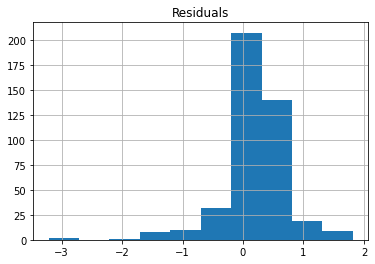

In [69]:
#Check to see if the residuals are Normally Distributed
#This check helps to determine the accuracy of the model

df_results.hist('Residuals');